### Lending club dataset

https://www.kaggle.com/datasets/wordsforthewise/lending-club


### Main objectives

1. Perform EDA.
2. Do Statistical data analysis.
3. Create a machine learning model to classify loans into accepted/rejected<br>
4. Predict the grade for the loan<br>
5. Predict the subgrade and the interest rate

#### Importing required Modules

In [158]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import scipy.stats as stats
import scikit_posthocs as sph
import pickle
import warnings
import os
import shap
import xgboost as xgb
from scipy.stats import f_oneway, anderson, kstest, skew
from functions import *
from typing import Optional, List, Union
from mpl_toolkits.axes_grid1 import make_axes_locatable
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler
from pyod.models.iforest import IForest
from collections import Counter, defaultdict
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from hyperopt import hp, fmin, tpe, Trials, space_eval
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    KFold,
    cross_val_score,
)
from sklearn.preprocessing import (
    StandardScaler,
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
)
from sklearn.feature_selection import SequentialFeatureSelector, RFECV
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve,
    PrecisionRecallDisplay,
    classification_report,
    accuracy_score,
    ConfusionMatrixDisplay,
    roc_auc_score,
    mean_squared_error,
    r2_score,
)
import joblib
from io import BytesIO
from google.cloud import storage

warnings.filterwarnings("ignore")

sns.set_palette("pastel")
pd.set_option("display.max_columns", None)
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

#### Setting access to reach GCP bucket

In [96]:
os.environ[
    "GOOGLE_APPLICATION_CREDENTIALS"
] = r"C:\Users\matas\tc34_gcp_cred\lending-club33-4e9dfb31ee6c.json"
storage_client = storage.Client()
bucket = storage_client.bucket("bucket-for-lending")

<IPython.core.display.Javascript object>

In [97]:
def float_format(x):
    return "{:.2f}".format(x)


pd.options.display.float_format = float_format

<IPython.core.display.Javascript object>

#### Loading Data

In [213]:
df_accepted = pd.read_csv("accepted_2007_to_2018Q4.csv")
df_rejected = pd.read_csv("rejected_2007_to_2018Q4.csv")

<IPython.core.display.Javascript object>

In [ ]:
emplymnt_length_order = [
    "< 1 year",
    "1 year",
    "2 years",
    "3 years",
    "4 years",
    "5 years",
    "6 years",
    "7 years",
    "8 years",
    "9 years",
    "10+ years",
]

<IPython.core.display.Javascript object>

### EDA and Cleaning

Since we will need to create a model to classify  accepted and rejected loans, we need to find the common columns in both datasets.

In [ ]:
df_rejected.head(5)

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.00,2007-05-26,Wedding Covered but No Honeymoon,693.00,10%,481xx,NM,4 years,0.00
1,1000.00,2007-05-26,Consolidating Debt,703.00,10%,010xx,MA,< 1 year,0.00
2,11000.00,2007-05-27,Want to consolidate my debt,715.00,10%,212xx,MD,1 year,0.00
3,6000.00,2007-05-27,waksman,698.00,38.64%,017xx,MA,< 1 year,0.00
4,1500.00,2007-05-27,mdrigo,509.00,9.43%,209xx,MD,< 1 year,0.00


<IPython.core.display.Javascript object>

In [ ]:
df_accepted.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.00,3600.00,3600.00,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.00,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.00,Aug-2003,675.00,679.00,1.00,30.00,NaN,7.00,0.00,2765.00,29.70,13.00,w,0.00,0.00,4421.72,4421.72,3600.00,821.72,0.00,0.00,0.00,Jan-2019,122.67,NaN,Mar-2019,564.00,560.00,0.00,30.00,1.00,Individual,NaN,NaN,NaN,0.00,722.00,144904.00,2.00,2.00,0.00,1.00,21.00,4981.00,36.00,3.00,3.00,722.00,34.00,9300.00,3.00,1.00,4.00,4.00,20701.00,1506.00,37.20,0.00,0.00,148.00,128.00,3.00,3.00,1.00,4.00,69.00,4.00,69.00,2.00,2.00,4.00,2.00,5.00,3.00,4.00,9.00,4.00,7.00,0.00,0.00,0.00,3.00,76.90,0.00,0.00,0.00,178050.00,7746.00,2400.00,13734.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.00,24700.00,24700.00,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.00,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.00,Dec-1999,715.00,719.00,4.00,6.00,NaN,22.00,0.00,21470.00,19.20,38.00,w,0.00,0.00,25679.66,25679.66,24700.00,979.66,0.00,0.00,0.00,Jun-2016,926.35,NaN,Mar-2019,699.00,695.00,0.00,NaN,1.00,Individual,NaN,NaN,NaN,0.00,0.00,204396.00,1.00,1.00,0.00,1.00,19.00,18005.00,73.00,2.00,3.00,6472.00,29.00,111800.00,0.00,0.00,6.00,4.00,9733.00,57830.00,27.10,0.00,0.00,113.00,192.00,2.00,2.00,4.00,2.00,NaN,0.00,6.00,0.00,5.00,

<IPython.core.display.Javascript object>

After taking a closer look, it seems that the following columns are present in both datasets, and will be used for modelling:<br>
"funded_amnt",<br>
"emp_length", <br>
"fico_score / risk_score",<br> 
"dti / debt-to-income ratio",<br> 
"state / addr_state"

#### Fico score - df_accepted
Fico in df_accepted represents the same meaning as risk_score in df_rejected. Accepted loans dataset have fico_range_low and fico_range_high values. Let's analyze them further:

In [ ]:
(df_accepted["fico_range_high"] - df_accepted["fico_range_low"]).describe()

count   2260668.00
mean          4.00
std           0.01
min           4.00
25%           4.00
50%           4.00
75%           4.00
max           5.00
dtype: float64

<IPython.core.display.Javascript object>

In [ ]:
(df_accepted["fico_range_high"] - df_accepted["fico_range_low"]).value_counts()

4.00    2260227
5.00        441
dtype: int64

<IPython.core.display.Javascript object>

In accepted loans dataset, the difference between fico low and high score is always 4. In rare cases, it is 5. Since we need to have risk_score in one dimensional format to match the rejected loans dataset format, I will calculate the average of these values.

In [245]:
df_accepted["fico"] = (
    df_accepted["fico_range_low"] + df_accepted["fico_range_high"]
) / 2

df_accepted.drop(["fico_range_low", "fico_range_high"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

#### Duplicates and missing values

In [ ]:
print_shape(df_accepted)
print_n_duplicates_missing(df_accepted)

There are 2260701 entries and 150 features
There are 0 duplicates.
Null values: 108486216


<IPython.core.display.Javascript object>

In [ ]:
print_shape(df_rejected)
print_n_duplicates_missing(df_rejected)

There are 27648741 entries and 9 features
There are 157954 duplicates.
Null values: 19451521


<IPython.core.display.Javascript object>

It looks that both datasets have quite a lot of missing values. Let's check which columns have the most missing values.

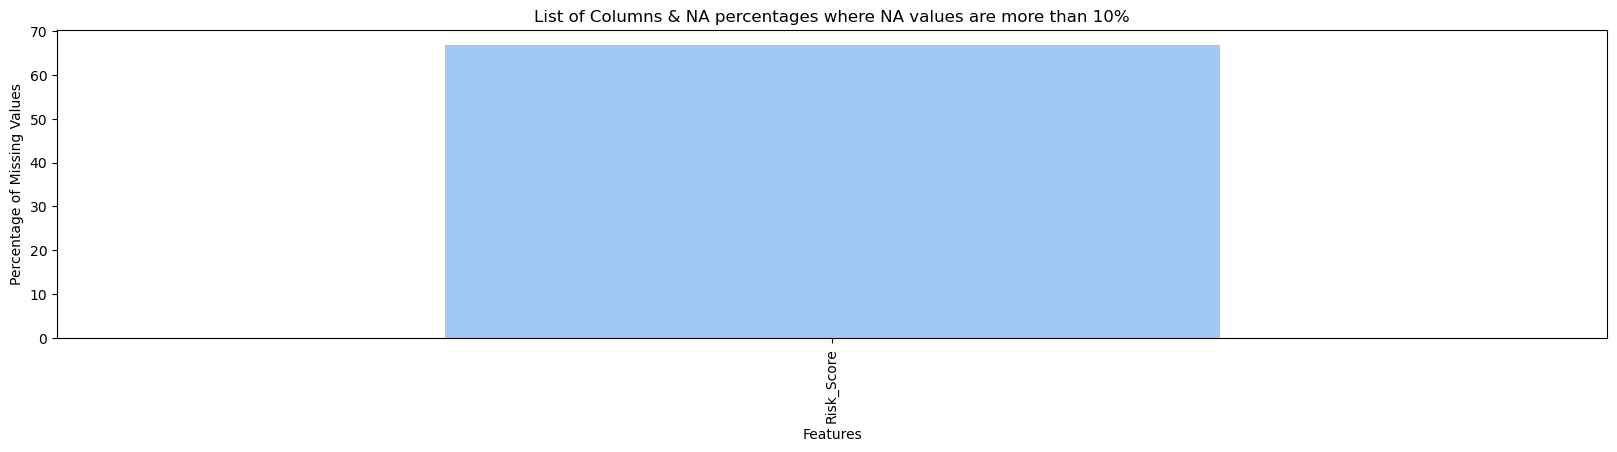

<IPython.core.display.Javascript object>

In [ ]:
get_cols_with_missing_values(df_rejected, 10)

In [ ]:
df_rejected.isna().sum()

Amount Requested               0
Application Date               0
Loan Title                  1303
Risk_Score              18497630
Debt-To-Income Ratio           0
Zip Code                     293
State                         22
Employment Length         951355
Policy Code                  918
dtype: int64

<IPython.core.display.Javascript object>

Only Risk_Score has high percentage of missing values (~65%). No other features have more than 10% of missing data. Given the highly imbalanced dataset with 26.7M rejected and 2.2M accepted instances, I won't attempt to impute missing values for the rejected dataset. Instead, I will drop duplicates and rows with missing values to ensure a clean dataset. Imputing such a large number of missing values could introduce bias and is unnecessary due to the abundance of data.

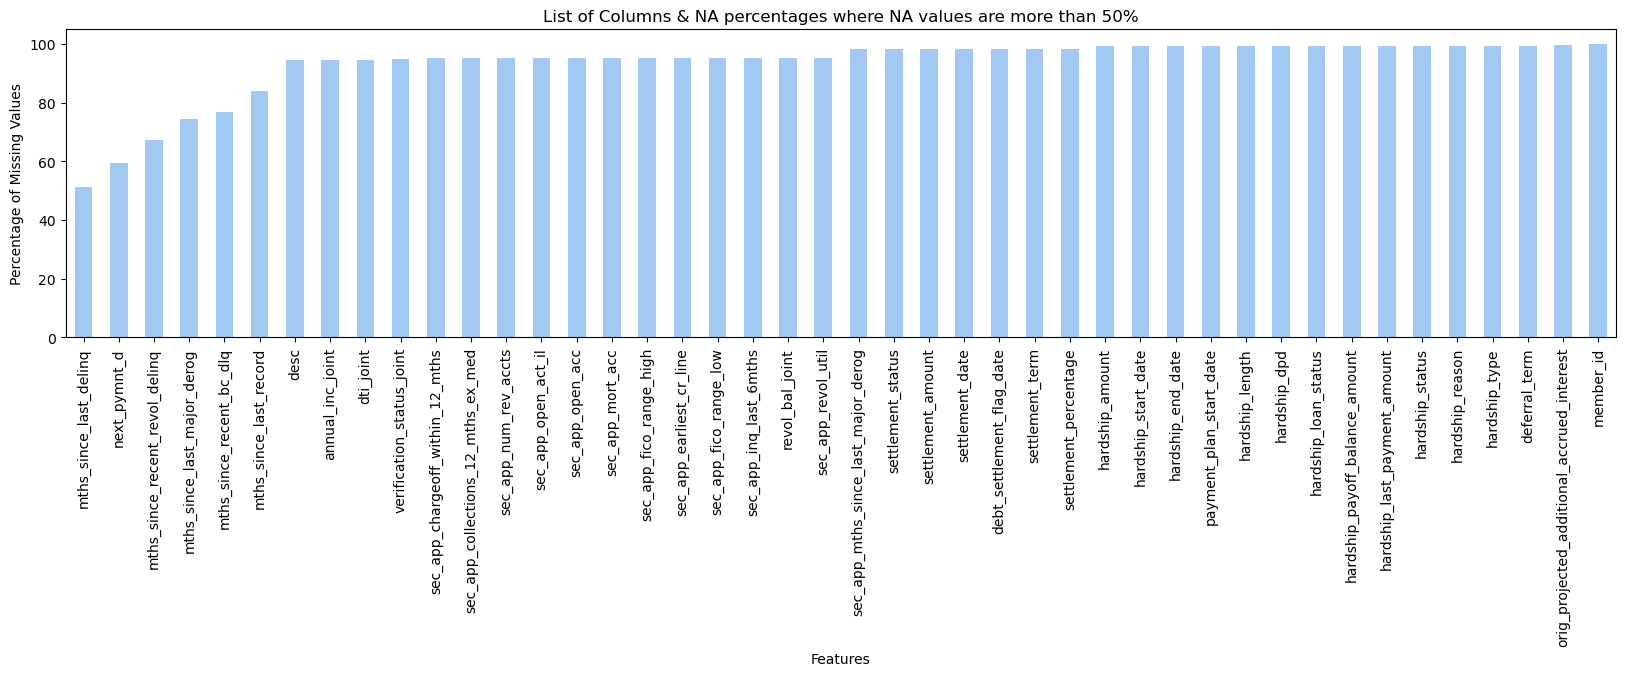

<IPython.core.display.Javascript object>

In [ ]:
get_cols_with_missing_values(df_accepted, 50)

#### DTI - df_accepted

I have noticed, that for joint applications, there are separate created features as "dti_joint", which we are going to use in decision modelling. Rejected loans dataset do not have a separation by application type, therefore to minimize the missing values for the first model, let's check if we could merge dti and dti_joint columns for first model. 

In [ ]:
df_accepted["dti"].isna().value_counts()

False    2258957
True        1744
Name: dti, dtype: int64

<IPython.core.display.Javascript object>

In [ ]:
df_accepted["dti_joint"].notna().value_counts()

False    2139995
True      120706
Name: dti_joint, dtype: int64

<IPython.core.display.Javascript object>

In [ ]:
df_accepted["application_type"].value_counts()

Individual    2139958
Joint App      120710
Name: application_type, dtype: int64

<IPython.core.display.Javascript object>

It looks that amount of joint applications almost matches the amount of dti_joint values. However, there are way less missing values for general "dti" column than 120710(amount of joint applications), let's investigate it further.

In [ ]:
dti_jointapp_indexes = df_accepted[df_accepted["application_type"] == "Joint App"][
    "dti"
].index
dti_jointapp = df_accepted[df_accepted["application_type"] == "Joint App"]["dti"]
dti_jointapp

2         10.78
168       20.67
438       17.56
509       35.70
529       22.70
           ... 
2260613   13.32
2260620   14.59
2260626   13.73
2260663   22.06
2260679   11.42
Name: dti, Length: 120710, dtype: float64

<IPython.core.display.Javascript object>

In [ ]:
(df_accepted.loc[dti_jointapp_indexes, "dti_joint"] == dti_jointapp).value_counts()

False    120482
True        228
dtype: int64

<IPython.core.display.Javascript object>

Only nearly 0.2% of values seems to be the same ("dti" == "dti_joint") when join_application==True. I am assuming, that "dti" shows debt-to-income ratio of the main person who filled the application, and "dti_joint" shows the dti value of 2 or more people who applied for joint loan. For rejected/accepted modelling we should use "dti_joint" value for joint applications.

#### Cleaning the format of Debt To Income rate

In [ ]:
df_rejected["Debt-To-Income Ratio"] = (
    pd.to_numeric(df_rejected["Debt-To-Income Ratio"].str.rstrip("%")) / 100
)
df_accepted["dti"] = df_accepted["dti"] / 100
df_accepted["dti_joint"] = df_accepted["dti_joint"] / 100

<IPython.core.display.Javascript object>

#### Let's make the dataframe for accepted/rejected model, clean dti and dti_joint columns, and split to train/test samples.

In [ ]:
# Creating new dataframes with same features from accepted and rejected dataframes for modelling
df_accepted_decision = df_accepted[
    [
        "funded_amnt",
        "emp_length",
        "fico",
        "dti",
        "dti_joint",
        "application_type",
        "addr_state",
    ]
].copy()
df_accepted_decision.rename(
    columns={
        "funded_amnt": "Amount Requested",
        "fico": "Risk_Score",
        "dti": "Debt-To-Income Ratio",
        "addr_state": "State",
    },
    inplace=True,
)
df_accepted_decision["is_accepted"] = 1

df_rejected_decision = df_rejected[
    [
        "Amount Requested",
        "Employment Length",
        "Risk_Score",
        "Debt-To-Income Ratio",
        "State",
    ]
].copy()
df_rejected_decision.rename(
    columns={
        "Employment Length": "emp_length",
    },
    inplace=True,
)
df_rejected_decision["is_accepted"] = 0

<IPython.core.display.Javascript object>

In [ ]:
df_accepted_decision["Debt-To-Income Ratio"] = np.where(
    df_accepted_decision["application_type"] == "Joint App",
    df_accepted_decision["dti_joint"],
    df_accepted_decision["Debt-To-Income Ratio"],
)

<IPython.core.display.Javascript object>

In [ ]:
df_accepted_decision.drop(["dti_joint", "application_type"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [ ]:
df_loan_decision = pd.concat([df_rejected_decision, df_accepted_decision])

<IPython.core.display.Javascript object>

In [ ]:
df_loan_decision = df_loan_decision.drop_duplicates().dropna()

<IPython.core.display.Javascript object>

In [ ]:
# How the dataframe for first model looks like?
df_loan_decision.head(5)

,Amount Requested,emp_length,Risk_Score,Debt-To-Income Ratio,State,is_accepted
0,1000.00,4 years,693.00,0.10,NM,0
1,1000.00,< 1 year,703.00,0.10,MA,0
2,11000.00,1 year,715.00,0.10,MD,0
3,6000.00,< 1 year,698.00,0.39,MA,0
4,1500.00,< 1 year,509.00,0.09,MD,0


<IPython.core.display.Javascript object>

We will continue with this df once we will start modelling.

#### Continuing EDA

In [ ]:
print(df_accepted["dti"].describe())
print(f"Skewness coef.:{df_accepted['dti'].skew():.2f}")

count   2258957.00
mean          0.19
std           0.14
min          -0.01
25%           0.12
50%           0.18
75%           0.24
max           9.99
Name: dti, dtype: float64
Skewness coef.:29.20


<IPython.core.display.Javascript object>

In [ ]:
print(df_rejected["Debt-To-Income Ratio"].describe())
print(f"Skewness coef.:{df_rejected['Debt-To-Income Ratio'].skew():.2f}")

count   27648741.00
mean           1.43
std          105.39
min           -0.01
25%            0.08
50%            0.20
75%            0.37
max       500000.31
Name: Debt-To-Income Ratio, dtype: float64
Skewness coef.:3906.80


<IPython.core.display.Javascript object>

We can clearly see that Debt-To-Income Ratio (further dti) is much more spreaded out compared to accepted loans dataset. (mean 0.19 vs 1.38 / std 0.12 vs 44.5). This huge difference could be explained by distribution of rejected loans dataset, it has big right skewnes. Max values differs by a lot (9.99 vs 73748.26) and Skewness coef. (23.66 vs 593.26). Later on, we will compare how average dti differs per employment length when comparing both data samples. 

#### Employment length distribution

<Figure size 1400x1000 with 0 Axes>

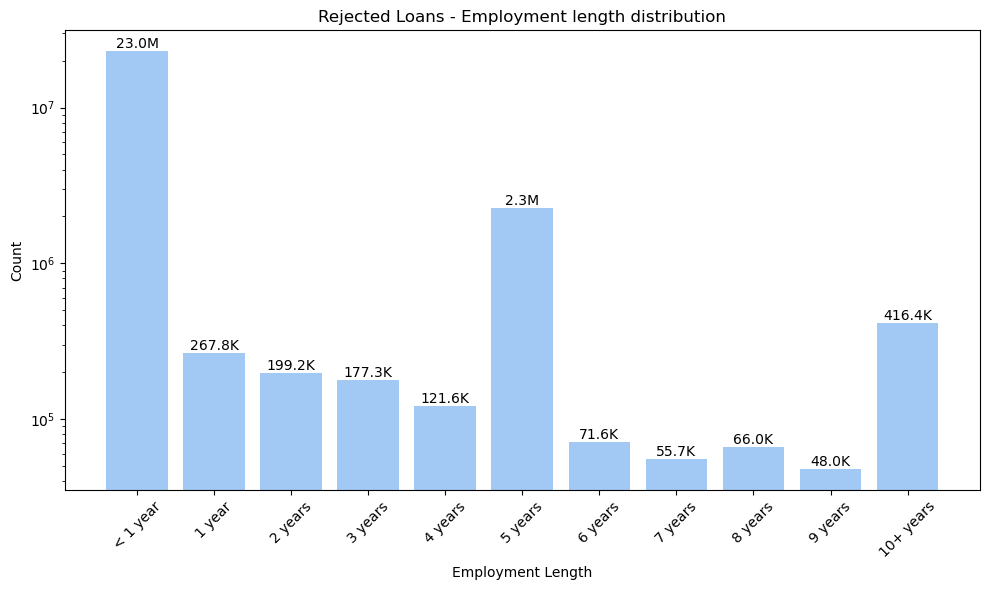

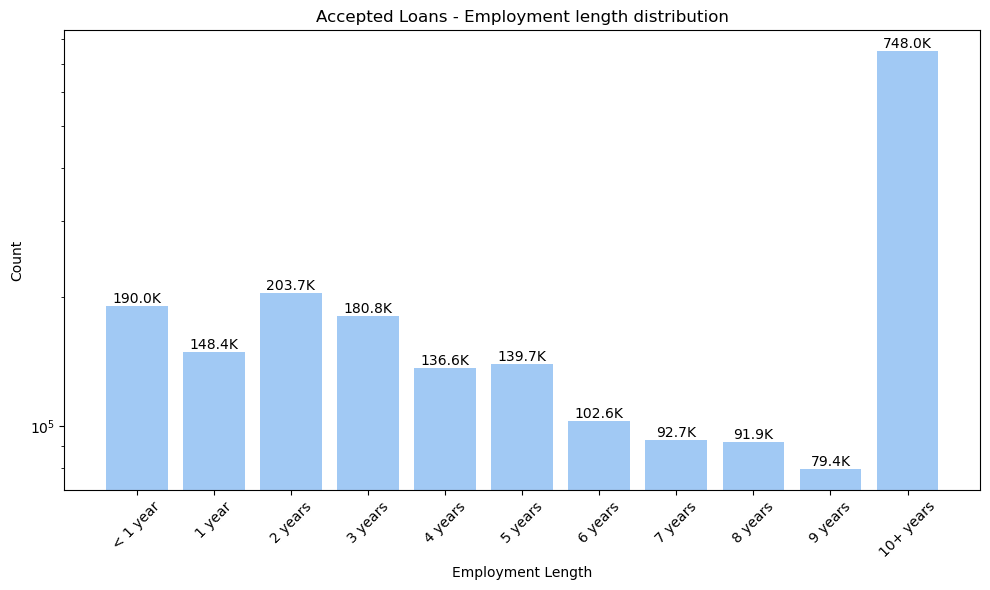

<IPython.core.display.Javascript object>

In [ ]:
plt.figure(figsize=(14, 10))
plot_categorical_distribution_with_order(
    df_rejected,
    "Employment Length",
    "Rejected Loans - Employment length distribution",
    "Employment Length",
    "Count",
    emplymnt_length_order,
    rotation=45,
    log_scale=True,
)
plot_categorical_distribution_with_order(
    df_accepted,
    "emp_length",
    "Accepted Loans - Employment length distribution",
    "Employment Length",
    "Count",
    emplymnt_length_order,
    rotation=45,
    log_scale=True,
)

We can see that the majority of people in accepted loans dataset have 10+ years of work experience. While for rejected loans - up to 1 year and 5 years. Please not that log scale was used on x axis due to huge difference in numbers on rejected loans dataset.

#### Debt-to-income ratio comparison

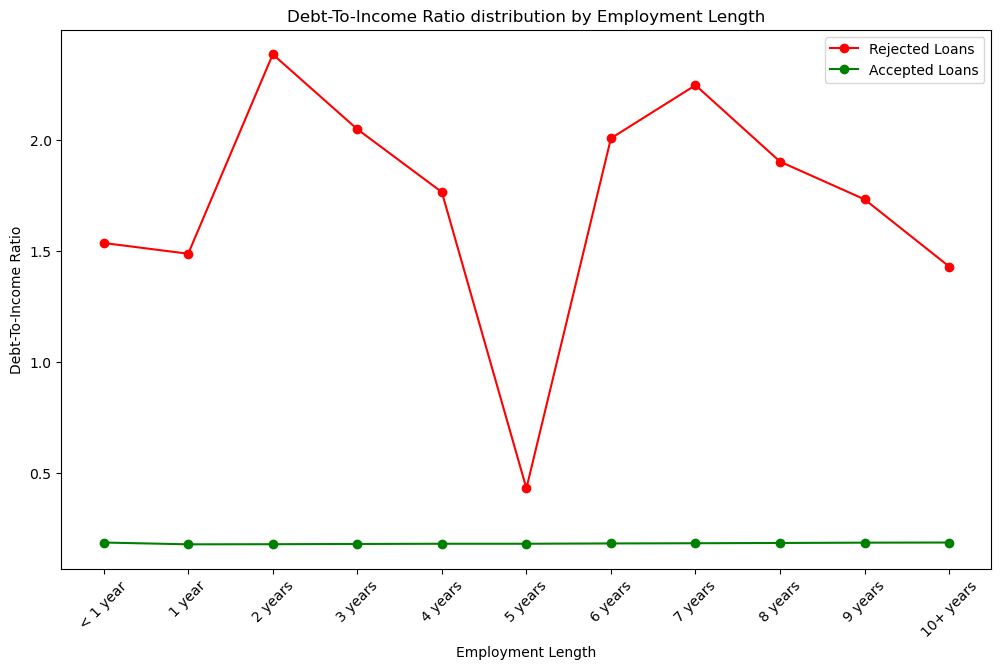

<IPython.core.display.Javascript object>

In [ ]:
rejected_means = (
    df_rejected.groupby("Employment Length")["Debt-To-Income Ratio"]
    .mean()
    .reindex(emplymnt_length_order)
)
accepted_means = (
    df_accepted.groupby("emp_length")["dti"].mean().reindex(emplymnt_length_order)
)

plt.figure(figsize=(12, 7))
plt.plot(
    rejected_means.index,
    rejected_means.values,
    marker="o",
    label="Rejected Loans",
    color="red",
)

plt.plot(
    accepted_means.index,
    accepted_means.values,
    marker="o",
    label="Accepted Loans",
    color="green",
)

plt.xlabel("Employment Length")
plt.ylabel("Debt-To-Income Ratio")
plt.title("Debt-To-Income Ratio distribution by Employment Length")
plt.xticks(rotation=45)
plt.legend(loc="upper right", bbox_to_anchor=(1, 1))
plt.subplots_adjust(wspace=0.2)
plt.show()

It is clearly noticable, that applications in rejected loans dataset, having a much higher DTI ratio. For rejected loans it is ranging around from 1.5-2.5, while 0.4 is an outlier for the employment Length of 5 years. DTI for accepted loans through all employment length durations is 0.18 on average

#### Risk / FICO score analysis

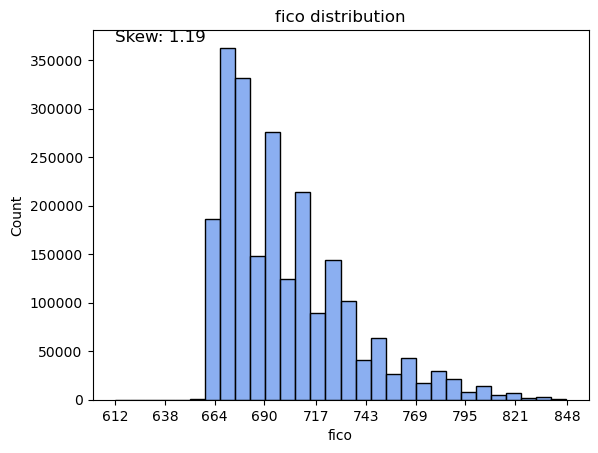

<IPython.core.display.Javascript object>

In [ ]:
plot_displot(df_accepted["fico"])

In [ ]:
df_accepted["fico"].describe()

count   2260668.00
mean        700.59
std          33.01
min         612.00
25%         677.00
50%         692.00
75%         717.00
max         847.50
Name: fico, dtype: float64

<IPython.core.display.Javascript object>

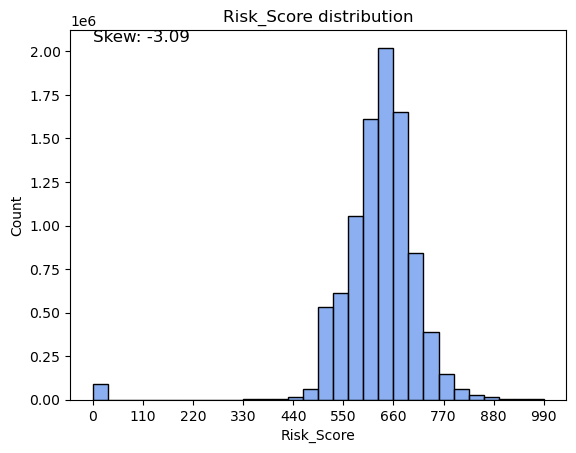

<IPython.core.display.Javascript object>

In [ ]:
plot_displot(df_rejected["Risk_Score"])

In [ ]:
df_rejected["Risk_Score"].describe()

count   9151111.00
mean        628.17
std          89.94
min           0.00
25%         591.00
50%         637.00
75%         675.00
max         990.00
Name: Risk_Score, dtype: float64

<IPython.core.display.Javascript object>

#### How it will be distributed after removing outliers?

In [ ]:
rej_no_outliers = remove_outliers(df_rejected, "Risk_Score")

Old Shape:  (27648741, 9)
New Shape:  (27444388, 9)
Values dropped: 204353


<IPython.core.display.Javascript object>

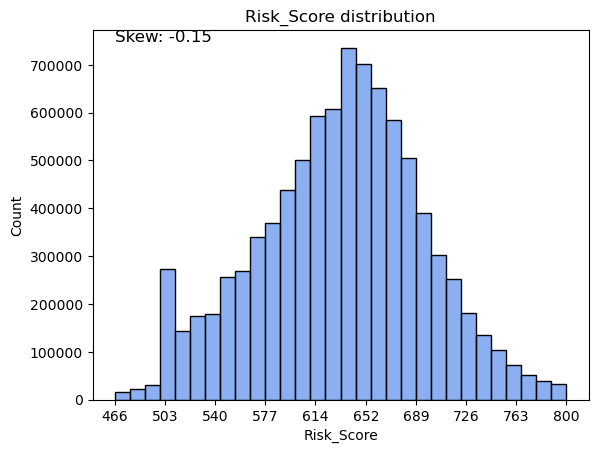

<IPython.core.display.Javascript object>

In [ ]:
plot_displot(rej_no_outliers["Risk_Score"])

In [ ]:
rej_no_outliers["Risk_Score"].describe()

count   8946758.00
mean        632.71
std          61.97
min         466.00
25%         593.00
50%         637.00
75%         674.00
max         800.00
Name: Risk_Score, dtype: float64

<IPython.core.display.Javascript object>

We notice that accepted loans tend to have a higher risk score than rejected loans. The lowest value for accepted application is 612, and the mean is 700. While for rejected loans we can see that the mean is 628, and 75% of the values falls below 675, not even reaching the accepted loans mean. After removing the outliers from the rejected loans dataset, situations didn't changed much - mean has changed by 4 points. 

#### In which states there are most rejected loans?

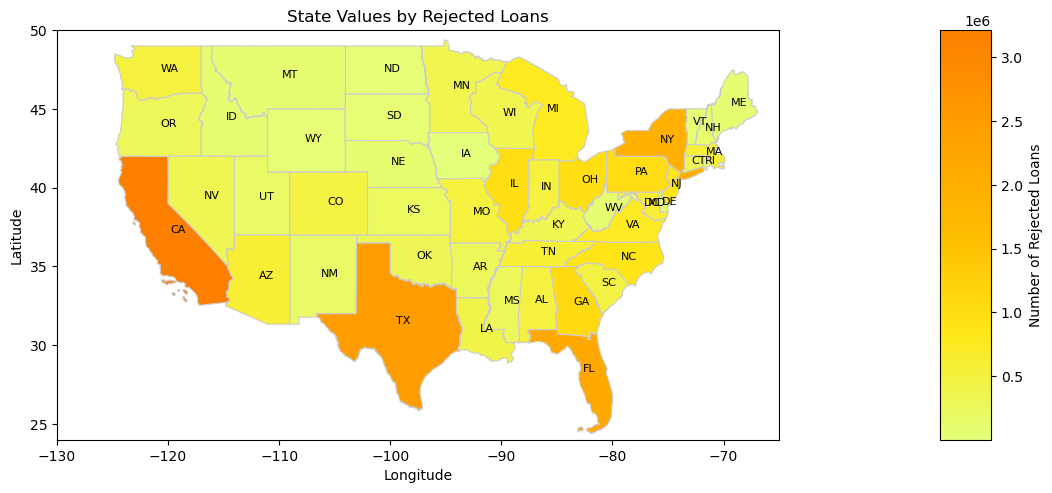

<IPython.core.display.Javascript object>

In [ ]:
rej_state_count = df_rejected["State"].value_counts().rej_state_count = (
    df_rejected["State"].value_counts().reset_index()
)
rej_state_count.columns = ["State", "n_rej_loans"]
us_states = gpd.read_file('usshapefiles/tl_2022_us_state.shp')
merged_data = us_states.merge(rej_state_count,left_on='STUSPS', right_on="State")

fig, ax = plt.subplots(1, 1, figsize=(14, 12))

merged_data.plot(column='n_rej_loans', cmap='Wistia', linewidth=0.8, ax=ax, edgecolor='0.8', legend=False, missing_kwds={'color': 'black'})

for state in merged_data.itertuples():
    x, y = state.geometry.centroid.x, state.geometry.centroid.y
    state_code = state.STUSPS
    ax.annotate(state_code, xy=(x, y), xytext=(-1, -1), textcoords="offset points", fontsize=8, color='black')

ax.set_xlim([-130, -65])
ax.set_ylim([24, 50])
ax.set_title('State Values by Rejected Loans')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(ax.collections[0], cax=cax, orientation='vertical', label='Number of Rejected Loans')

plt.show()


The highest number of rejected loans in this dataset are in California, Texas, New York and Florida states.

#### Grade and Subgrade analysis

In [ ]:
df_accept_analysis = df_accepted.dropna(subset=["grade","sub_grade", "int_rate", "dti", "emp_length"])


<IPython.core.display.Javascript object>

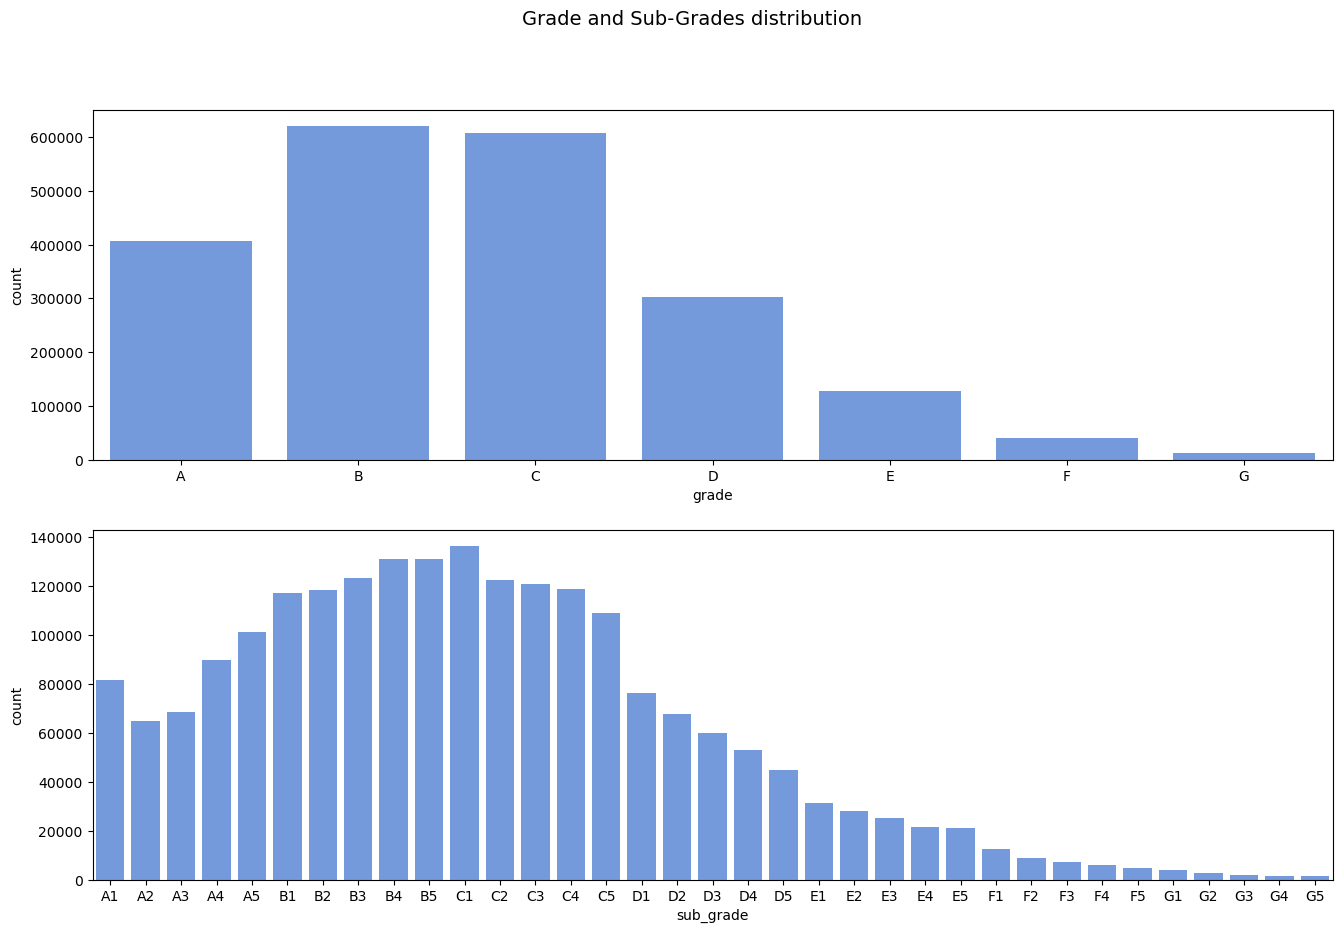

<IPython.core.display.Javascript object>

In [ ]:
#### Grade and Sub-Grades distribution
plt.figure(figsize=(16, 10))
plt.subplot(2, 1, 1)
sns.countplot(
    x="grade",
    data=df_accept_analysis,
    order=sorted(df_accept_analysis["grade"].unique()),
    color="cornflowerblue",
)


plt.subplot(2, 1, 2)
sns.countplot(
    x="sub_grade",
    data=df_accept_analysis,
    order=sorted(df_accept_analysis["sub_grade"].unique()),
    color="cornflowerblue",
)

plt.suptitle("Grade and Sub-Grades distribution", fontsize=14)
plt.show()

In this data set, most often people receive B-C grades, B1-C5 subgrades. Top 3 are B4-C1. Absolute minority receives the worst F-G grades.

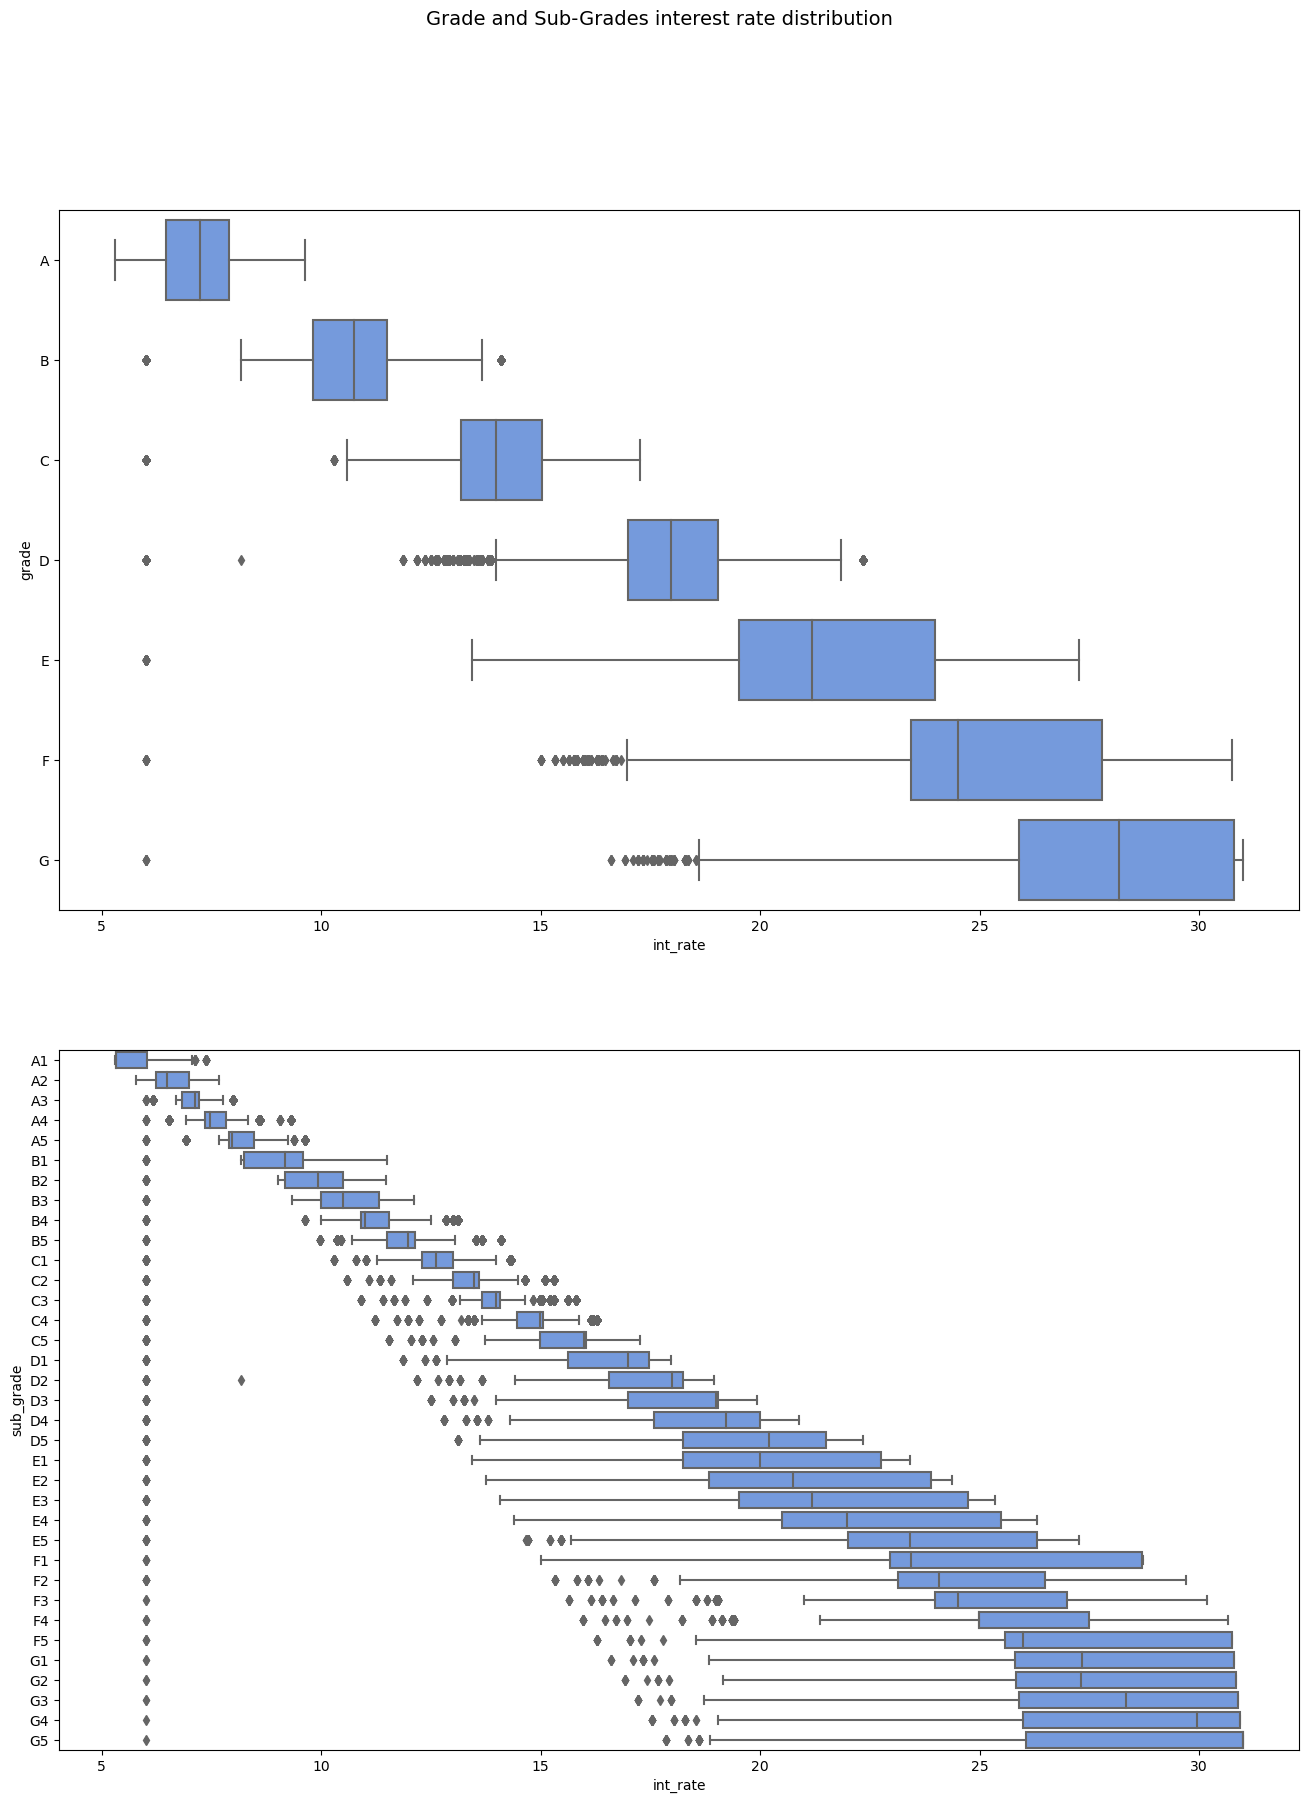

<IPython.core.display.Javascript object>

In [ ]:
#### Interest rates distribution between grades and sub-grades
plt.figure(figsize=(16, 20))
plt.subplot(2, 1, 1)
sns.boxplot(
    data=df_accept_analysis,
    x="int_rate",
    y="grade",
    order=sorted(df_accept_analysis["grade"].unique()),
    color="cornflowerblue",
)
plt.subplot(2, 1, 2)
sns.boxplot(
    data=df_accept_analysis,
    x="int_rate",
    y="sub_grade",
    order=sorted(df_accept_analysis["sub_grade"].unique()),
    color="cornflowerblue",
)
plt.suptitle("Grade and Sub-Grades interest rate distribution", fontsize=14)
plt.show()


Interest rates are increasing accordingly to the given grade or subgrade. The better the grade, the lower the interest rate. 

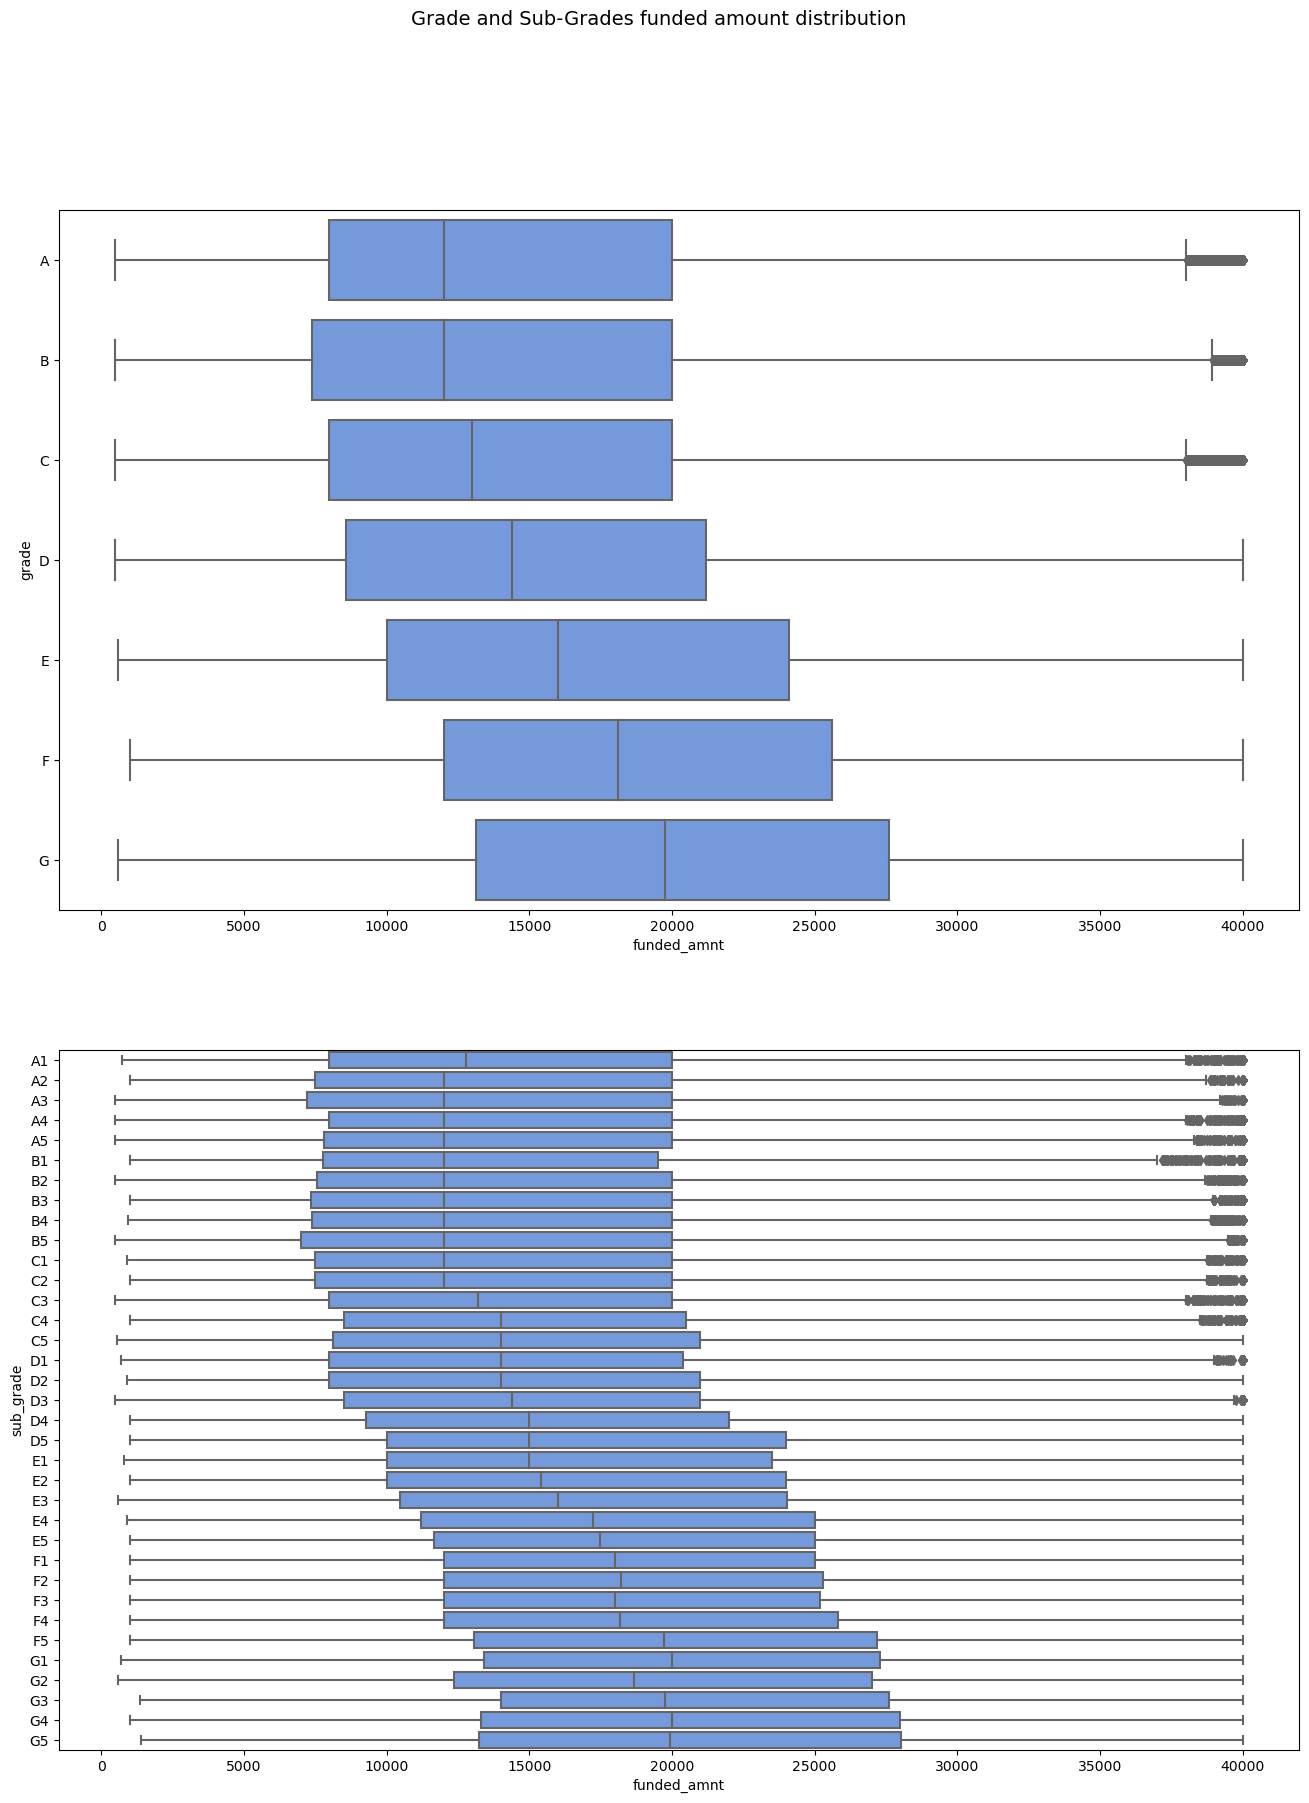

<IPython.core.display.Javascript object>

In [ ]:
#### Funded amount distribution by grades and sub-grades
plt.figure(figsize=(16, 20))
plt.subplot(2, 1, 1)
sns.boxplot(
    data=df_accepted,
    x="funded_amnt",
    y="grade",
    order=sorted(df_accept_analysis["grade"].unique()),
    color="cornflowerblue",
)
plt.subplot(2, 1, 2)
sns.boxplot(
    data=df_accepted,
    x="funded_amnt",
    y="sub_grade",
    order=sorted(df_accept_analysis["sub_grade"].unique()),
    color="cornflowerblue",
)
plt.suptitle("Grade and Sub-Grades funded amount distribution", fontsize=14)
plt.show()

By first look, there is no very significant difference in funded amounts. People are lending amounts in wide range. However, we can notice a pattern, that loans with a higher funded amounts tends to receive a worse rate.

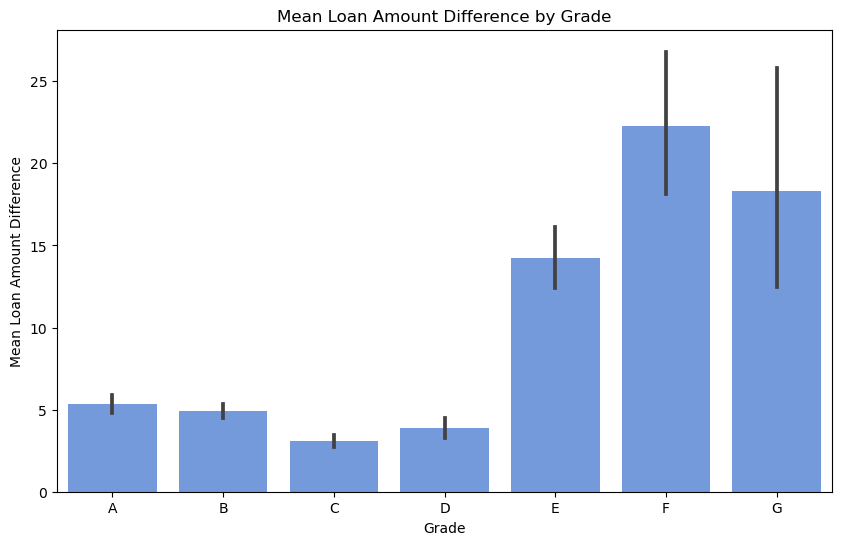

<IPython.core.display.Javascript object>

In [ ]:
#### What is the difference between asked and received amount for loan by grade?
df_accepted["loan_diff"] = df_accepted["loan_amnt"] - df_accepted["funded_amnt"]
plt.figure(figsize=(10, 6))
sns.barplot(
    x=df_accepted["grade"],
    y=df_accepted["loan_diff"],
    estimator=lambda x: x.mean(),
    order=sorted(df_accept_analysis["grade"].unique()),
    color="cornflowerblue",
)
plt.xlabel("Grade")
plt.ylabel("Mean Loan Amount Difference")
plt.title("Mean Loan Amount Difference by Grade")
plt.show()

On avarage, the loans with worse grades were funded by not a full requested amount more often.

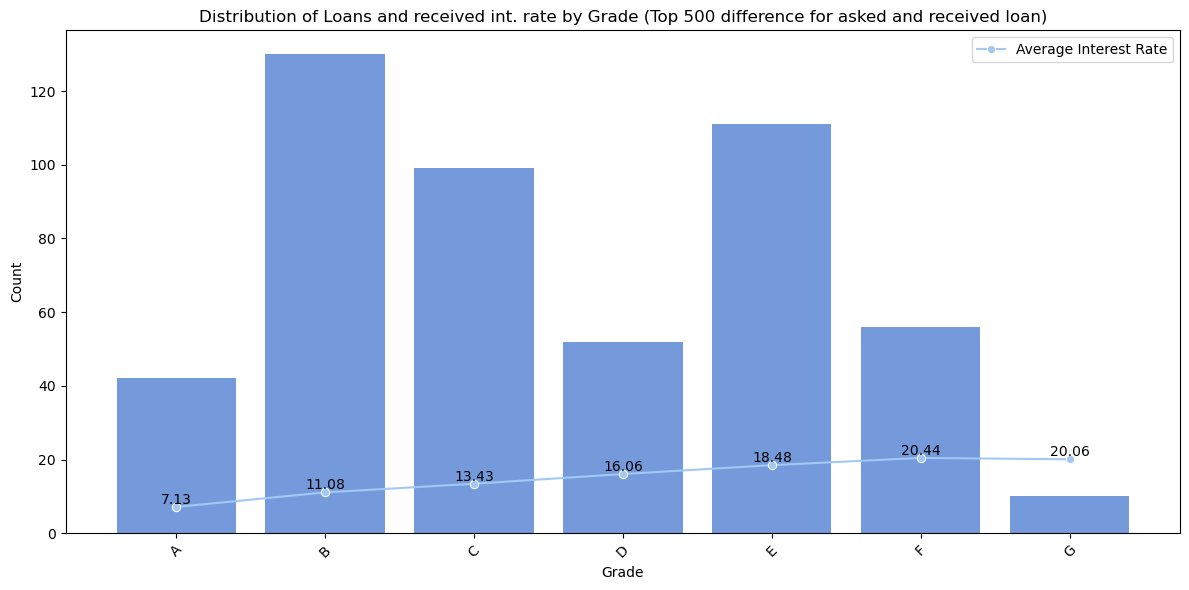

<IPython.core.display.Javascript object>

In [ ]:
#### For top 500 people with highest difference, what interest rates they received?

subset_df = df_accepted.nlargest(500, "loan_diff")

plt.figure(figsize=(12, 6))

sns.countplot(x="grade", data=subset_df, order=sorted(subset_df["grade"].unique()), ax=plt.gca(), color="cornflowerblue",)
plt.xlabel("Grade")
plt.ylabel("Count")
plt.title("Distribution of Loans and received int. rate by Grade (Top 500 difference for asked and received loan)")

avg_int_rate_by_grade = subset_df.groupby("grade")["int_rate"].mean().reset_index()
sns.lineplot(x="grade", y="int_rate", data=avg_int_rate_by_grade, marker="o", sort=False, ax=plt.gca())

for x, y in zip(avg_int_rate_by_grade["grade"], avg_int_rate_by_grade["int_rate"]):
    plt.text(x, y, f"{y:.2f}", ha='center', va='bottom')

plt.legend(labels=["Average Interest Rate"])

plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()


Interest rates were distributed according the rates people received, the higher the grade - the higher the interest rate. However, when looking at the top500 differences, a nearly half of top 500 people who didn't received their asked amount, had relatively good grades (B,C). In my opinion these people has chosen to get a lower funded amount in order to receive a better interest rate.

#### Correlations to Grades

In [239]:
# Grade Encoding
grade_ordinal_map = {"A": 6, "B": 5, "C": 4, "D": 3, "E": 2, "F": 1, "G": 0}
df_accepted["grade_encoded"] = df_accepted["grade"].map(grade_ordinal_map)

<IPython.core.display.Javascript object>

I will be calculating kendall corelation since we do not meet the assumptions of pearson correlation.

In [ ]:
grade_correlations = pd.Series(index=df_accepted.columns, dtype=float)
for col in df_accepted.columns:
    if col != "grade_encoded":
        if np.issubdtype(df_accepted[col].dtype, np.number):
            grade_correlations[col] = df_accepted["grade_encoded"].corr(df_accepted[col])

top_corr = grade_correlations.nsmallest(10).append(grade_correlations.nlargest(10)).sort_values()


<IPython.core.display.Javascript object>

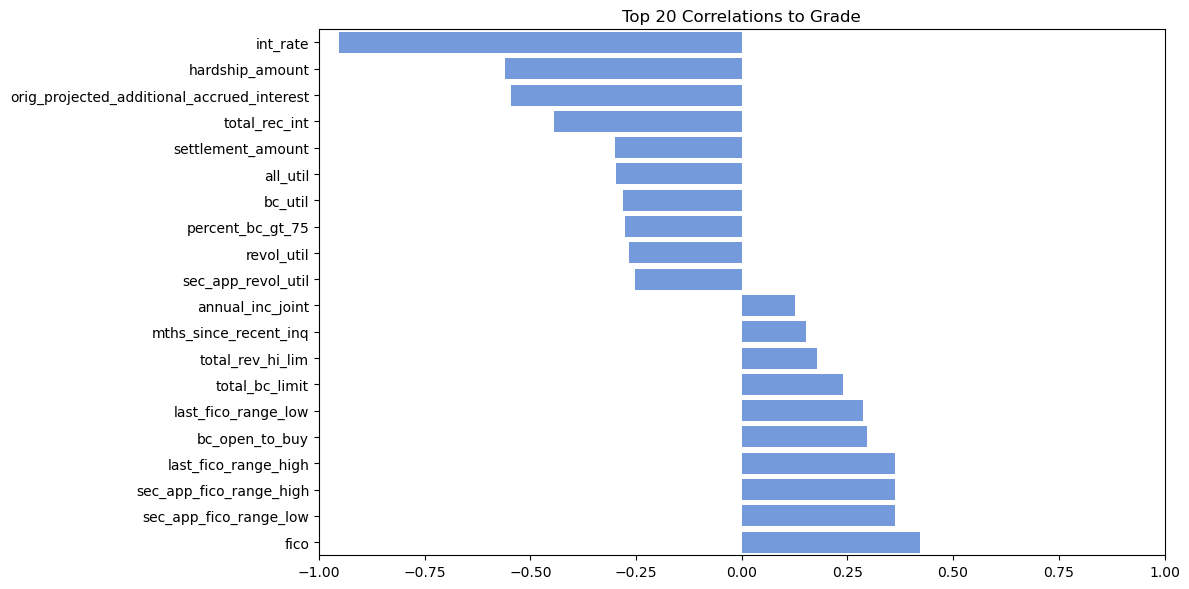

<IPython.core.display.Javascript object>

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_corr.values,
    y=top_corr.index,
    color="cornflowerblue",
)
plt.title("Top 20 Correlations to Grade")
plt.xlim(-1, 1)
plt.tight_layout()
plt.show()

<b>Looking at negative correlations, assigned grade is mostly correlated to:</b><br> 
int_rate,<br>
hardship_amount,<br>
percent_bc_gt_75 (percentage of bankcards (credit cards) for which the credit limit is greater than 75% utilized) <br>
Various credit utilization variables (how much client is relying on a credit)
<br><br>
<b>Looking at positive correlations:</b><br> 
"fico" (risk score), <br> 
bc_open_to_buy (how much person can still lend with credit card) <br>
total_rev_hi_lim (sum of the high credit limits across all revolving credit accounts, such as credit cards.), <br>
mnths_since_recent_inq

#### Top words of loan purpose for rejected and accepted loans

In [ ]:
rejected_titles = top_words(df_rejected, "Loan Title", 2, 5)
rejected_titles = pd.DataFrame.from_dict(rejected_titles, orient="index")

accepted_titles = top_words(df_accepted, "title", 2, 5)
accepted_titles = pd.DataFrame.from_dict(accepted_titles, orient="index")

<IPython.core.display.Javascript object>

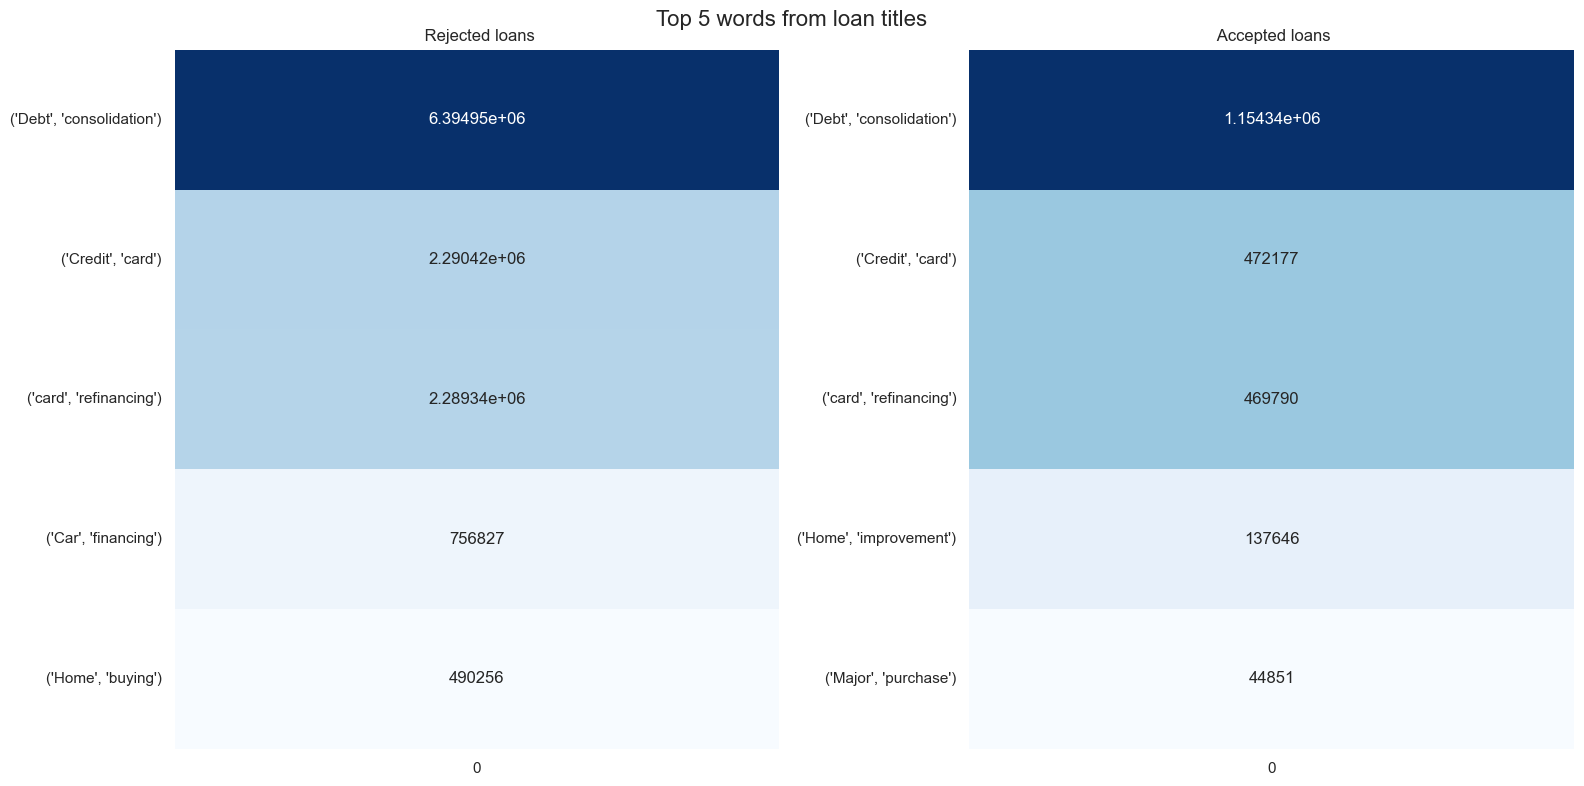

<IPython.core.display.Javascript object>

In [ ]:
sns.set()

fig, axs = plt.subplots(ncols=2, figsize=(16, 8))

sns.heatmap(rejected_titles, cmap="Blues", annot=True, fmt="g", ax=axs[0], cbar=False)
axs[0].set_title("\n Rejected loans")

sns.heatmap(accepted_titles, cmap="Blues", annot=True, fmt="g", ax=axs[1], cbar=False)
axs[1].set_title("\n Accepted loans")

fig.tight_layout()
fig.suptitle("Top 5 words from loan titles", fontsize=16)
plt.show()

The most popular loan titles doesn't seem to be much different between accepted and rejected loans:<br>
Debt consolidation,<br>
Credit card refinancing, <br> 
Home buying/Improvement,<br>
Major purchase 

### Statistical inference

In [ ]:
grades = sorted(df_accept_analysis["grade"].unique())

<IPython.core.display.Javascript object>

In [ ]:
emp_length_ordinal_map = {
    "< 1 year": 0.0,
    "1 year": 1.0,
    "2 years": 2.0,
    "3 years": 3.0,
    "4 years": 4.0,
    "5 years": 5.0,
    "6 years": 6.0,
    "7 years": 7.0,
    "8 years": 8.0,
    "9 years": 9.0,
    "10+ years": 10.0,
}

df_accept_analysis["emp_length_encoded"] = df_accept_analysis["emp_length"].map(
    emp_length_ordinal_map
)

<IPython.core.display.Javascript object>

#### Funded amount vs Loan Grade
During EDA we have have found out that loans with better grades tends to have smaller funded amounts. Let's check if there are a significant difference in funded amounts across different loan grades.

In [ ]:
funded_amnt_by_grade = {}
for grade in grades:
    funded_amnt_by_grade[grade] = df_accept_analysis[
        df_accept_analysis["grade"] == grade
    ]["funded_amnt"]

<IPython.core.display.Javascript object>

In [ ]:
for grade, data in funded_amnt_by_grade.items():
    print(f"Funded amounts for Grade {grade[-1]}:")
    check_normality(data)

Funded amounts for Grade A:
Skewness coef.: 0.94
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

Funded amounts for Grade B:
Skewness coef.: 0.95
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

Funded amounts for Grade C:
Skewness coef.: 0.73
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

Funded amounts for Grade D:
Skewness coef.: 0.54
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

Funded amounts for Grade E:
Skewness coef.: 0.31
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

Funded amounts for Grade F:
Skewness coef.: 0.15
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

Funded amounts for Grade G:
Skewness coef.: 0.12
Anderson-Darling Test: Not normally distributed
Kolmogoro

<IPython.core.display.Javascript object>

Both, Anderson-Darling and Kolmogorov-Smirnov shows that data samples from all grades are not normally distributed, even F and G grades have quite a small skewness coefficient - 0.12/0.15. Let's check if after log transformation we can achieve normal distribution.

In [ ]:
for grade, data in funded_amnt_by_grade.items():
    print(f"Funded amounts for Grade {grade[-1]}:")
    check_normality(np.log1p(data))

Funded amounts for Grade A:
Skewness coef.: -0.48


Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

Funded amounts for Grade B:
Skewness coef.: -0.52
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

Funded amounts for Grade C:
Skewness coef.: -0.72
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

Funded amounts for Grade D:
Skewness coef.: -0.87
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

Funded amounts for Grade E:
Skewness coef.: -1.24
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

Funded amounts for Grade F:
Skewness coef.: -1.46
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

Funded amounts for Grade G:
Skewness coef.: -1.49
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 



<IPython.core.display.Javascript object>

Data is still not normally distributed, therefore I will use non-parametric Kruskal–Wallis test instead of ANOVA.

#### Hypotheses
H0: There is no signifficant difference in funded amount between loan grades <br>
HA: There is signifficant difference in funded amount between loan grades

Alpha: 0.05

In [ ]:
model = stats.kruskal(*funded_amnt_by_grade.values())
get_significance(model.pvalue)

'P value is below alpha 0.05 --> Reject H0.'

<IPython.core.display.Javascript object>

#### Post-hoc Dunn test


In [ ]:
print(
    f"Since we comparing multiple groups at once, the chance of getting Type I error is: {((1 - (1 - 0.05) ** 21)*100):.2f}%"
)

Since we comparing multiple groups at once, the chance of getting Type I error is: 65.94%


<IPython.core.display.Javascript object>

Therefore to control it, we have to adjust our alpha to:

In [ ]:
alpha = 0.05 / 21
alpha

0.002380952380952381

<IPython.core.display.Javascript object>

More information of above calculations: Family-wise error rate https://www.statology.org/family-wise-error-rate/

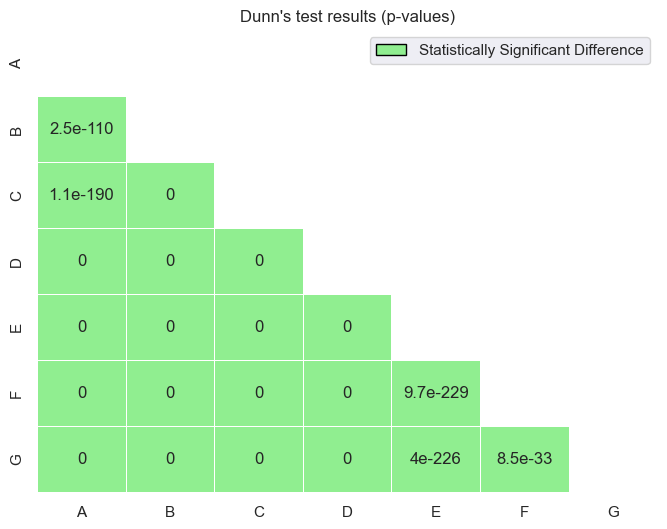

<IPython.core.display.Javascript object>

In [ ]:
dunn_test_funded_amnt = sph.posthoc_dunn(list(funded_amnt_by_grade.values()))
dunn_test_funded_amnt.columns = list(funded_amnt_by_grade.keys())
dunn_test_funded_amnt.index = list(funded_amnt_by_grade.keys())

plot_dunn_results(dunn_test_funded_amnt, alpha)

Even with highly adjusted alpha value, we found out, that there is a signifanct difference between all loan grades when comparing the funded amounts.

### Debt to income comparison between loan grades

##### Collecting data for each group

In [ ]:
dti_by_grade = {}
for grade in grades:
    dti_by_grade[grade] = df_accept_analysis[df_accept_analysis["grade"] == grade][
        "dti"
    ]

<IPython.core.display.Javascript object>

##### Checking data skewness

In [ ]:
for grade, data in dti_by_grade.items():
    print(f"DTI for Grade {grade[-1]}:")
    check_normality(data)

DTI for Grade A:
Skewness coef.: 25.47
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

DTI for Grade B:
Skewness coef.: 27.53
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

DTI for Grade C:
Skewness coef.: 21.68
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

DTI for Grade D:
Skewness coef.: 21.22
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

DTI for Grade E:
Skewness coef.: 23.73
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

DTI for Grade F:
Skewness coef.: 14.72
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

DTI for Grade G:
Skewness coef.: 31.78
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 



<IPython.core.display.Javascript object>

In [ ]:
for grade, data in dti_by_grade.items():
    print(f"DTI for Grade {grade[-1]}:")
    check_normality(np.log1p(data))

DTI for Grade A:
Skewness coef.: 2.36
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

DTI for Grade B:
Skewness coef.: 2.48
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

DTI for Grade C:
Skewness coef.: 2.05
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

DTI for Grade D:
Skewness coef.: 1.91
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

DTI for Grade E:
Skewness coef.: 1.95
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

DTI for Grade F:
Skewness coef.: 1.47
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

DTI for Grade G:
Skewness coef.: 3.66
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 



<IPython.core.display.Javascript object>

Applying various transformations did not helped to achieve a normal distribution. Therefore, we will use non-parametric statistical tests.

##### Hypotheses
H0: There is no signifficant difference in debt-to-income rate between loan grades<br>
HA: There is signifficant difference in debt-to-income rate between loan grades 

Alpha: 0.05

In [ ]:
model = stats.kruskal(*dti_by_grade.values())
get_significance(model.pvalue)

'P value is below alpha 0.05 --> Reject H0.'

<IPython.core.display.Javascript object>

Alpha adjusted for Dunn test: 0.002380952380952381

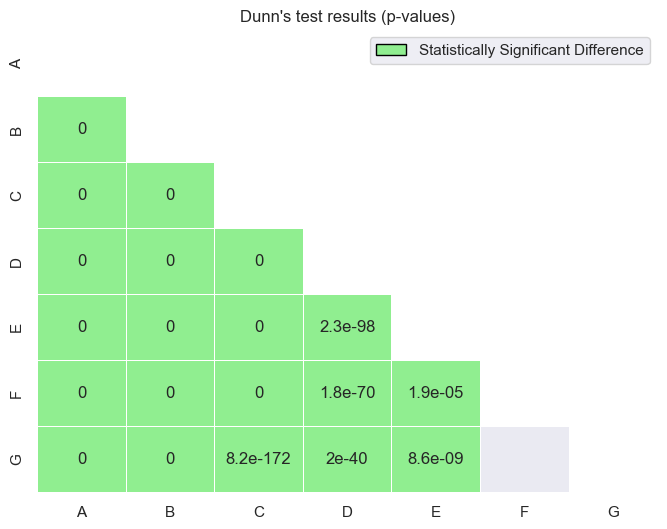

<IPython.core.display.Javascript object>

In [ ]:
dunn_test_dti = sph.posthoc_dunn(list(dti_by_grade.values()))
dunn_test_dti.columns = list(dti_by_grade.keys())
dunn_test_dti.index = list(dti_by_grade.keys())

plot_dunn_results(dunn_test_dti, alpha)

There is a significant difference in DTI between all loan grades except, when comparing F and G grades.

#### emp_length comparison between loan grades

In [ ]:
emp_length_by_grade = {}
for grade in grades:
    emp_length_by_grade[grade] = df_accept_analysis[
        df_accept_analysis["grade"] == grade
    ]["emp_length_encoded"]

<IPython.core.display.Javascript object>

In [ ]:
for grade, data in emp_length_by_grade.items():
    print(f"Grade {grade[-1]}:")
    check_normality(data)

Grade A:
Skewness coef.: -0.23
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

Grade B:
Skewness coef.: -0.21
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

Grade C:
Skewness coef.: -0.18
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

Grade D:
Skewness coef.: -0.18
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

Grade E:
Skewness coef.: -0.20
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

Grade F:
Skewness coef.: -0.24
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 

Grade G:
Skewness coef.: -0.21
Anderson-Darling Test: Not normally distributed
Kolmogorov-Smirnov Test: Not normally distributed 



<IPython.core.display.Javascript object>

Data is normally distributed and we will use a non parametric tests Kruskall Wallis and Dunn's test

##### Hypotheses
H0: There is no signifficant difference in employment length between loan grades<br>
HA: There is signifficant difference in employment length between loan grades 

Alpha: 0.05

In [ ]:
model = stats.kruskal(*emp_length_by_grade.values())
get_significance(model.pvalue)

'P value is below alpha 0.05 --> Reject H0.'

<IPython.core.display.Javascript object>

Adjusted Alpha for Dunn test: 0.002380952380952381

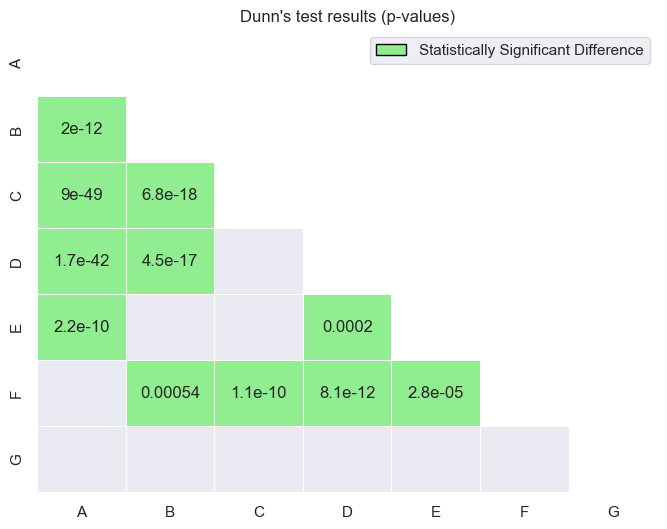

<IPython.core.display.Javascript object>

In [ ]:
dunn_test_emp_length = sph.posthoc_dunn(list(emp_length_by_grade.values()))
dunn_test_emp_length.columns = list(emp_length_by_grade.keys())
dunn_test_emp_length.index = list(emp_length_by_grade.keys())

plot_dunn_results(dunn_test_emp_length, alpha)

The results shows that there is no significant difference in employment length when comparing G loan grade to all others, this could tell us that lack of work experience is not the main reason why the bad grade was received looking overall. We didn't also found any significant difference betweeen grades A-F, E-B, E-C, D-C in employment length. 

### Machine Learning

### Modelling

#### Loan decision accepted/rejected model

Why this type of model is important?

Enhances the accuracy of identifying creditworthy applicants, reducing the risk of defaults and financial losses. Automating loan decisions with ML speeds up processing, allowing for handling more applications faster and at a lower cost.

In [ ]:
df_loan_decision

,Amount Requested,emp_length,Risk_Score,Debt-To-Income Ratio,State,is_accepted
0,1000.00,4 years,693.00,0.10,NM,0
1,1000.00,< 1 year,703.00,0.10,MA,0
2,11000.00,1 year,715.00,0.10,MD,0
3,6000.00,< 1 year,698.00,0.39,MA,0
4,1500.00,< 1 year,509.00,0.09,MD,0
...,...,...,...,...,...,...
2260693,24000.00,4 years,727.00,0.11,HI,1
2260694,24000.00,7 years,667.00,0.20,AL,1
2260695,24000.00,10+ years,697.00,0.35,UT,1
2260696,40000.00,9 years,707.00,0.13,CA,1


<IPython.core.display.Javascript object>

In [ ]:
df_loan_decision.reset_index(inplace=True, drop=True)

<IPython.core.display.Javascript object>

In [ ]:
df_loan_decision.isna().any()

Amount Requested        False
emp_length              False
Risk_Score              False
Debt-To-Income Ratio    False
State                   False
is_accepted             False
dtype: bool

<IPython.core.display.Javascript object>

We do not have any null values. So I will go ahead to encode the dataset.

####  Encoding

In [ ]:
state_encoder = LabelEncoder()
df_loan_decision["State"] = state_encoder.fit_transform(df_loan_decision["State"])

<IPython.core.display.Javascript object>

In [ ]:
emp_length_ordinal_map = {
    "< 1 year": 0.0,
    "1 year": 1.0,
    "2 years": 2.0,
    "3 years": 3.0,
    "4 years": 4.0,
    "5 years": 5.0,
    "6 years": 6.0,
    "7 years": 7.0,
    "8 years": 8.0,
    "9 years": 9.0,
    "10+ years": 10.0,
}

df_loan_decision["emp_length"] = df_loan_decision["emp_length"].replace(emp_length_ordinal_map)


<IPython.core.display.Javascript object>

In [ ]:
X_train_dec, X_test_dec, y_train_dec, y_test_dec = train_test_sets(
    df_loan_decision, "is_accepted"
)

<IPython.core.display.Javascript object>

#### Removing outliers from train split

I will use Isolation Forest to detect and clean my training dataset from outliers. Iforest is also often used in detecting outliers in live data, to prevent inserting them into deployed model.

In [ ]:
iforest_dec = IForest()
iforest_dec.fit(X_train_dec)
outlier_predictions_dec = iforest_dec.predict(X_train_dec)

<IPython.core.display.Javascript object>

In [ ]:
X_train_dec = X_train_dec[outlier_predictions_dec == 0]
y_train_dec = y_train_dec[outlier_predictions_dec == 0]

<IPython.core.display.Javascript object>

#### Balancing

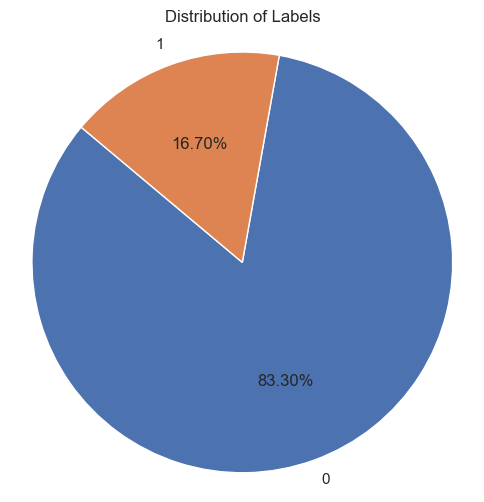

<IPython.core.display.Javascript object>

In [ ]:
plot_pie_distribution(y_train_dec)

In [ ]:
undersample = RandomUnderSampler(sampling_strategy="majority")

print(Counter(y_train_dec))
X_train_dec, y_train_dec = undersample.fit_resample(X_train_dec, y_train_dec)

print(Counter(y_train_dec))

Counter({0: 7198915, 1: 1443621})
Counter({0: 1443621, 1: 1443621})


<IPython.core.display.Javascript object>

I won't be imputing any values, as we do have a lot of values in accepted loans dataset, which will be enough to train the model.

#### Scaling

In [ ]:
blob = bucket.blob(f"scalers/scaler_decision.pkl")
cols_scale = ["Amount Requested", "Risk_Score", "Debt-To-Income Ratio"]
if blob.exists():
    print(f"Loading Scaler from GCS: scalers/scaler_decision.pkl")
    byte_stream = BytesIO()
    blob.download_to_file(byte_stream)
    byte_stream.seek(0)
    scaler_dec = joblib.load(byte_stream)

    X_train_dec[cols_scale] = scaler_dec.transform(X_train_dec[cols_scale])
    X_test_dec[cols_scale] = scaler_dec.transform(X_test_dec[cols_scale])
else:
    scaler_dec = StandardScaler()
    X_train_dec[cols_scale] = scaler_dec.fit_transform(X_train_dec[cols_scale])
    X_test_dec[cols_scale] = scaler_dec.transform(X_test_dec[cols_scale])

Loading Scaler from GCS: scalers/scaler_decision.pkl


<IPython.core.display.Javascript object>

In [ ]:
scaler_dec = StandardScaler()
X_train_dec[cols_scale] = scaler_dec.fit_transform(X_train_dec[cols_scale])
X_test_dec[cols_scale] = scaler_dec.transform(X_test_dec[cols_scale])

<IPython.core.display.Javascript object>

#### Feature selection

In [ ]:
blob = bucket.blob(f"feature_selectors/decision_sequential_fs1.pkl")
if blob.exists():
    print(
        f"Loading Feature selector from GCS: feature_selectors/decision_sequential_fs1.pkl"
    )
    byte_stream = BytesIO()
    blob.download_to_file(byte_stream)
    byte_stream.seek(0)
    selector_dec = joblib.load(byte_stream)
else:
    selector_dec = SequentialFeatureSelector(
        XGBClassifier(random_state=42), n_features_to_select=3, scoring="f1"
    )
    selector_dec.fit(X_train_dec, y_train_dec)

    blob = bucket.blob(f"feature_selectors/decision_sequential_fs1.pkl")

    byte_stream = BytesIO()
    joblib.dump(selector_dec, byte_stream)
    byte_stream.seek(0)

    blob.upload_from_file(byte_stream, content_type="application/octet-stream")
    print(
        f"Sequential feature selector saved to GCP bucket: feature_selectors/decision_sequential_fs1.pkl"
    )

Loading Feature selector from GCS: feature_selectors/decision_sequential_fs1.pkl


<IPython.core.display.Javascript object>

In [ ]:
selected_features = X_train_dec.columns[selector_dec.support_]

<IPython.core.display.Javascript object>

In [ ]:
X_train_dec[selected_features]

,emp_length,Risk_Score,Debt-To-Income Ratio
3218448,0.00,-0.74,0.94
6870659,0.00,-1.80,-1.06
1030087,0.00,0.56,3.81
2117105,0.00,1.90,-0.55
5251814,0.00,1.48,3.81
...,...,...,...
10526850,7.00,0.15,-0.30
9628519,1.00,-0.02,-0.63
9524682,10.00,0.15,-0.60
9958614,2.00,0.74,0.24


<IPython.core.display.Javascript object>

It doesn't look right, that along the selected features we do not have a feature of "Amount Requested", maybe a model could explain the decision only by a profile of a lender, but looking into a real world scenarios, I believe that can't be deployed to production. I will increase the value of features to 4.

In [ ]:
blob = bucket.blob(f"feature_selectors/decision_sequential_fs4.pkl")
if blob.exists():
    print(
        f"Loading Feature selector from GCS: feature_selectors/decision_sequential_fs4.pkl"
    )
    byte_stream = BytesIO()
    blob.download_to_file(byte_stream)
    byte_stream.seek(0)
    selector_dec4 = joblib.load(byte_stream)
else:
    selector_dec4 = SequentialFeatureSelector(
        XGBClassifier(random_state=42), n_features_to_select=4, scoring="f1"
    )
    selector_dec4.fit(X_train_dec, y_train_dec)

    blob = bucket.blob(f"feature_selectors/decision_sequential_fs4.pkl")

    byte_stream = BytesIO()
    joblib.dump(selector_dec4, byte_stream)
    byte_stream.seek(0)

    blob.upload_from_file(byte_stream, content_type="application/octet-stream")
    print(
        f"Sequential feature selector saved to GCP bucket: feature_selectors/decision_sequential_fs4.pkl"
    )

Loading Feature selector from GCS: feature_selectors/decision_sequential_fs4.pkl


<IPython.core.display.Javascript object>

In [ ]:
selected_features = X_train_dec.columns[selector_dec4.support_]

<IPython.core.display.Javascript object>

In [ ]:
X_train_dec[selected_features]

,Amount Requested,emp_length,Risk_Score,Debt-To-Income Ratio
3218448,0.22,0.00,-0.74,0.94
6870659,-0.99,0.00,-1.80,-1.06
1030087,2.31,0.00,0.56,3.81
2117105,0.22,0.00,1.90,-0.55
5251814,-0.33,0.00,1.48,3.81
...,...,...,...,...
10526850,-0.88,7.00,0.15,-0.30
9628519,-0.13,1.00,-0.02,-0.63
9524682,-0.58,10.00,0.15,-0.60
9958614,1.20,2.00,0.74,0.24


<IPython.core.display.Javascript object>

Since it the modelling will be done with only 4 features, I will not do any hyperparameting. Let's check what results we will get with default settings.

In [ ]:
X_train_dec = X_train_dec[selected_features]
X_test_dec = X_test_dec[selected_features]

<IPython.core.display.Javascript object>

In [ ]:
blob_dec = bucket.blob("models/model_decision.pkl")
if blob_dec.exists():
    print(f"Loading model from GCS: models/model_decision.pkl")
    byte_stream = BytesIO()
    blob_dec.download_to_file(byte_stream)
    byte_stream.seek(0)
    dc_model_dec = joblib.load(byte_stream)


<IPython.core.display.Javascript object>

In [ ]:
if not blob_dec.exists():
    dc_model_dec = DecisionTreeClassifier(random_state=42)
    rf_model_dec = RandomForestClassifier(random_state=42)
    xgb_model_dec = XGBClassifier(random_state=42)

<IPython.core.display.Javascript object>

In [ ]:
if not blob_dec.exists():
    dc_model_dec.fit(X_train_dec, y_train_dec)

<IPython.core.display.Javascript object>

In [ ]:
if not blob_dec.exists():
    rf_model_dec.fit(X_train_dec, y_train_dec)

<IPython.core.display.Javascript object>

In [ ]:
if not blob_dec.exists():
    xgb_model_dec.fit(X_train_dec, y_train_dec)

<IPython.core.display.Javascript object>

In [100]:
if not blob_dec.exists():
    loan_decision_models = [
        ("XGB", xgb_model_dec),
        ("Decision Tree", dc_model_dec),
        ("Random Forest", rf_model_dec),
    ]

    combined_model_dec = VotingClassifier(
        estimators=loan_decision_models, voting="soft"
    )

    combined_model_dec.fit(X_train_dec, y_train_dec)
    loan_decision_models.append(("Combined", combined_model_dec))

<IPython.core.display.Javascript object>

#### Models evaluation

In [101]:
%%capture cap
if not blob_dec.exists():
    y_pred_rf = rf_model_dec.predict(X_test_dec)
    y_pred_xgb = xgb_model_dec.predict(X_test_dec)
    y_pred_dc = dc_model_dec.predict(X_test_dec)
    y_pred_comb = combined_model_dec.predict(X_test_dec)


    print("Random Forest Performance:")
    print(classification_report(y_test_dec, y_pred_rf))
    print("ROC AUC:", roc_auc_score(y_test_dec, y_pred_rf))
    print("----------------------------------------------------------")

    print("XGBoost Performance:")
    print(classification_report(y_test_dec, y_pred_xgb))
    print("ROC AUC:", roc_auc_score(y_test_dec, y_pred_xgb))
    print("----------------------------------------------------------")

    print("Decision Tree Performance:")
    print(classification_report(y_test_dec, y_pred_dc))
    print("ROC AUC:", roc_auc_score(y_test_dec, y_pred_dc))
    print("----------------------------------------------------------")

    print("Model Ensembler Performance:")
    print(classification_report(y_test_dec, y_pred_dc))
    print("ROC AUC:", roc_auc_score(y_test_dec, y_pred_dc))

<IPython.core.display.Javascript object>

In [102]:
if blob_dec.exists():
    with open("models_comparison_output/decision_models_comparison.txt", "r") as file:
        contents = file.read()
        print(contents)
else:
    with open("models_comparison_output/decision_models_comparison.txt", "w") as file:
        file.write(cap.stdout)
    print(cap.stdout)


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97    856581
           1       0.81      0.97      0.89    210399

    accuracy                           0.95   1066980
   macro avg       0.90      0.96      0.93   1066980
weighted avg       0.96      0.95      0.95   1066980

ROC AUC: 0.9591058919692108
----------------------------------------------------------
XGBoost Performance:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    856581
           1       0.82      0.98      0.89    210399

    accuracy                           0.95   1066980
   macro avg       0.91      0.97      0.93   1066980
weighted avg       0.96      0.95      0.96   1066980

ROC AUC: 0.965149136827544
----------------------------------------------------------
Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98

<IPython.core.display.Javascript object>

#### Best performing model Decision Tree

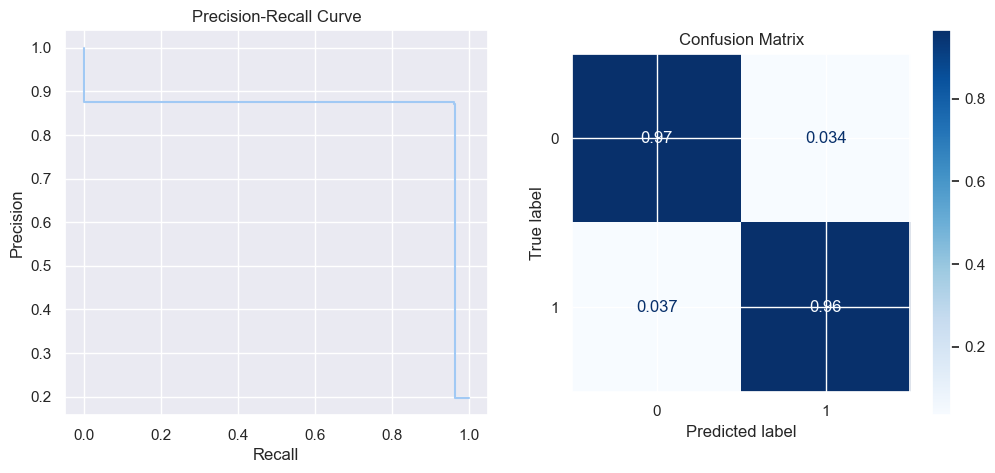

<IPython.core.display.Javascript object>

In [103]:
plot_precision_recall_and_confusion_matrix(dc_model_dec, X_test_dec, y_test_dec)

##### Results

All 3 models seems to be perfect in quality of predicting rejected loans. Precision (0.99-1), however, they tend to have more difficulties to predict accepted loans. Precision ranges (0.81-0.88) and recall (0.96-0.98), looking at f1-score decision tree performed the best - f1-score 0.98 for class 0 and 0.92 for class 1, accuracy -0.97.

Model Ensembler performed exactly the same as decision tree. That means, no other model were able to guess the values that decision tree got wrong. Therefore I will use decision tree.

##### Saving scaler and model

In [107]:
blob_dec_scaler = bucket.blob(f"scalers/scaler_decision.pkl")
if not blob_dec_scaler.exists():

    byte_stream = BytesIO()
    joblib.dump(scaler_dec, byte_stream)
    byte_stream.seek(0)
    blob_dec_scaler.upload_from_file(byte_stream, content_type='application/octet-stream')
    print(f"Scaler saved to GCP bucket: {blob_dec_scaler}")


<IPython.core.display.Javascript object>

In [108]:
if not blob_dec.exists():
    byte_stream = BytesIO()
    joblib.dump(dc_model_dec, byte_stream)
    byte_stream.seek(0)

    blob_dec.upload_from_file(byte_stream, content_type="application/octet-stream")
    print(f"Model saved to GCP bucket: {blob_dec}")

Model saved to GCP bucket: <Blob: bucket-for-lending, models/model_decision.pkl, 1712142903848081>


<IPython.core.display.Javascript object>

### Model for grade

Classifying loans into grades A to G and the subgrades A1-A5 and etc. enables more accurate interest rates based on each loan's risk, enhancing profitability and risk management. Detailed loan grades help institutions manage and diversify their loan portfolio's risk more effectively.

#### Preparing data for modelling

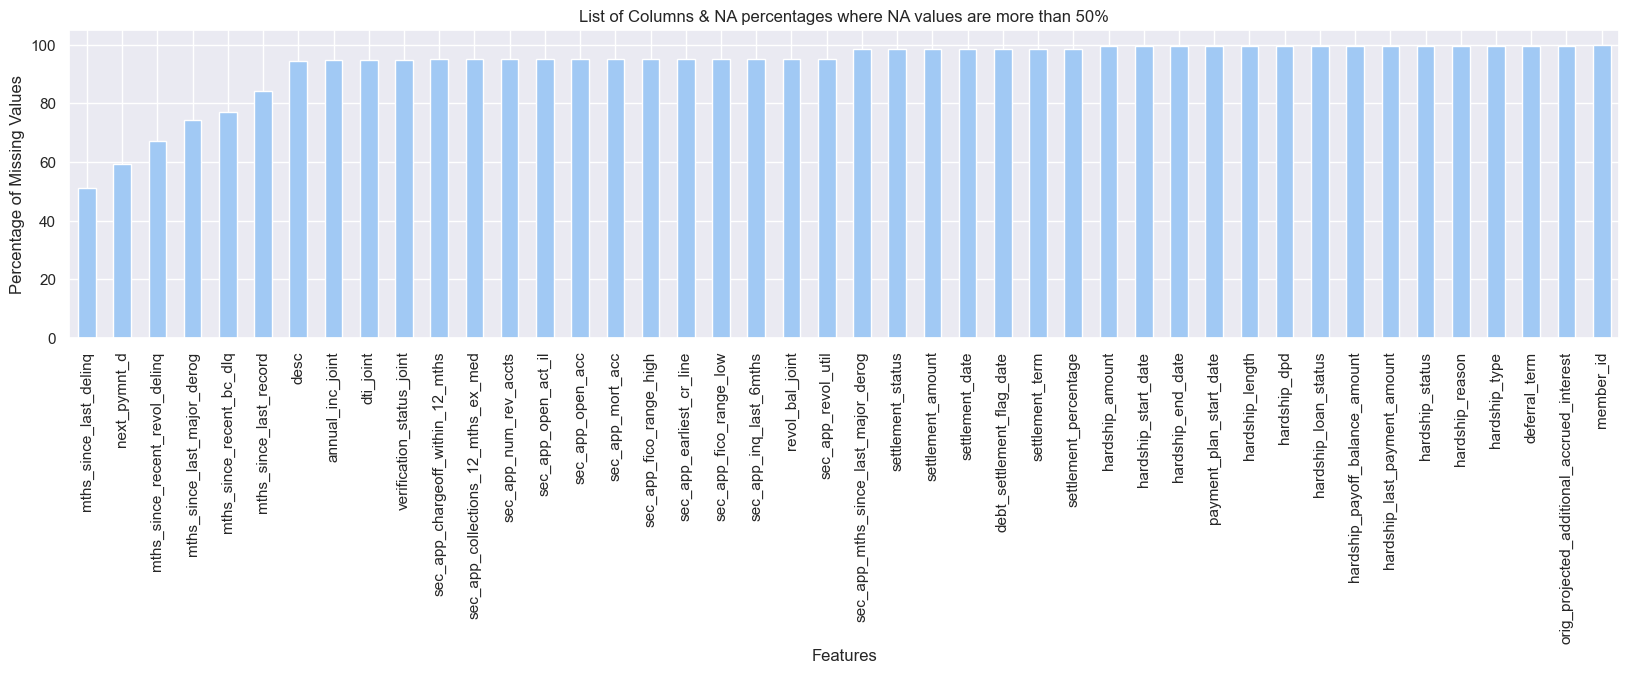

<IPython.core.display.Javascript object>

In [109]:
get_cols_with_missing_values(df_accepted, 50)

Most of these fetures, that have 50% and more of missing values are from joint applications, that only have a value, when application type is joint. They are named with words "joint"/"sec". Other features are containing information that wouldn't be available on date of filling the application for a loan. Therefore I will drop them together with features that contain texts (loan purpose / description). The list of these values are below:



In [223]:
df_accepted.drop(
    [
        "zip_code",
        "loan_status",
        "last_pymnt_d",
        "last_pymnt_amnt",
        "out_prncp",
        "out_prncp_inv",
        "total_pymnt",
        "total_pymnt_inv",
        "total_rec_prncp",
        "total_rec_int",
        "total_rec_late_fee",
        "recoveries",
        "collection_recovery_fee",
        "last_credit_pull_d",
        "last_fico_range_high",
        "last_fico_range_low",
        "title",
        "funded_amnt_inv",
        "emp_title",
        "url",
        "pymnt_plan",
        "id",
        "hardship_flag",
        "disbursement_method",
        "mths_since_last_delinq",
        "next_pymnt_d",
        "mths_since_recent_revol_delinq",
        "mths_since_last_major_derog",
        "mths_since_recent_bc_dlq",
        "desc",
        "settlement_status",
        "settlement_percentage",
        "hardship_amount",
        "hardship_start_date",
        "hardship_end_date",
        "payment_plan_start_date",
        "hardship_length",
        "hardship_dpd",
        "hardship_loan_status",
        "hardship_payoff_balance_amount",
        "hardship_last_payment_amount",
        "hardship_status",
        "hardship_reason",
        "hardship_type",
        "deferral_term",
        "member_id",
        "verification_status_joint",
        "settlement_date",
        "settlement_amount",
        "settlement_term",
        "debt_settlement_flag_date",
        "sec_app_earliest_cr_line",
    ],
    axis=1,
    inplace=True,
)

<IPython.core.display.Javascript object>

After not needed columns are dropped, I will drop rows, that have more than 50% of missing values. 

In [224]:
rows_missing_50perc = df_accepted.isna().sum(axis=1) > df_accepted.shape[1] * 0.5

<IPython.core.display.Javascript object>

In [225]:
rows_missing_50perc.value_counts()

False    2190392
True       70309
dtype: int64

<IPython.core.display.Javascript object>

In [226]:
print(f"That will be {(70309/2190392)*100:.2f}% of all rows")

That will be 3.21% of all rows


<IPython.core.display.Javascript object>

In [227]:
df_accepted = drop_rows_if(df_accepted, 0.5)

<IPython.core.display.Javascript object>

Right now we are going to fill remaining null values with -1. There are no indications, that NaN values can be interpreted as zeros in the context of the data. In many features having a value of 0 would be interpreted as really good or bad value, f.e. - opened loans / issued credit card numbers / months since last loan inquiry / public bankruptcies and etc. Therefore I have decided to fill the missing values with -1 to maintain a clear distinction between actual data points and missing values. So it would be interpreted as data is not available.

In [228]:
fill_neg1 = [
    "il_util",
    "all_util",
    "bc_util",
    "total_bc_limit",
    "total_bal_ex_mort",
    "pct_tl_nvr_dlq",
    "percent_bc_gt_75",
    "pub_rec_bankruptcies",
    "revol_util",
    "tax_liens",
    "tot_coll_amt",
    "tot_cur_bal",
    "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op",
    "mo_sin_rcnt_rev_tl_op",
    "mo_sin_rcnt_tl",
    "mths_since_rcnt_il",
    "mths_since_recent_bc",
    "mths_since_recent_inq",
    "max_bal_bc",
    "mort_acc",
    "num_accts_ever_120_pd",
    "num_actv_bc_tl",
    "num_actv_rev_tl",
    "num_bc_sats",
    "num_bc_tl",
    "num_il_tl",
    "num_op_rev_tl",
    "num_rev_accts",
    "num_rev_tl_bal_gt_0",
    "num_sats",
    "num_tl_120dpd_2m",
    "num_tl_30dpd",
    "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m",
    "open_acc_6m",
    "open_act_il",
    "open_il_12m",
    "open_il_24m",
    "inq_fi",
    "inq_last_12m",
    "inq_last_6mths",
    "acc_open_past_24mths",
    "avg_cur_bal",
    "bc_open_to_buy",
    "chargeoff_within_12_mths",
    "collections_12_mths_ex_med",
    "open_rv_12m",
    "open_rv_24m",
    "tot_hi_cred_lim",
    "total_bal_il",
    "total_il_high_credit_limit",
    "total_rev_hi_lim",
    "total_cu_tl",
    "orig_projected_additional_accrued_interest",
    "mths_since_last_record",
    "annual_inc_joint",
    "dti_joint",
    "revol_bal_joint",
    "sec_app_fico_range_low",
    "sec_app_fico_range_high",
    "sec_app_inq_last_6mths",
    "sec_app_mort_acc",
    "sec_app_open_acc",
    "sec_app_revol_util",
    "sec_app_open_act_il",
    "sec_app_num_rev_accts",
    "sec_app_chargeoff_within_12_mths",
    "sec_app_collections_12_mths_ex_med",
    "sec_app_mths_since_last_major_derog",
]
for col in fill_neg1:
    df_accepted[col].fillna(-1, inplace=True)

<IPython.core.display.Javascript object>

In [229]:
nan_counts = df_accepted.isna().sum()
nan_counts_sorted = nan_counts[nan_counts > 0]
nan_counts_sorted

emp_length    144846
dti             1711
dtype: int64

<IPython.core.display.Javascript object>

In [230]:
df_accepted[df_accepted["emp_length"].isna()]

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,policy_code,application_type,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,orig_projected_additional_accrued_interest,debt_settlement_flag
55,24000.00,24000.00,60 months,9.80,507.58,B,B3,NaN,OWN,77900.00,Not Verified,Dec-2015,home_improvement,TN,10.24,0.00,Oct-1982,740.00,744.00,1.00,-1.00,9.00,0.00,3454.00,10.30,21.00,w,0.00,1.00,Individual,-1.00,-1.00,0.00,0.00,127412.00,0.00,1.00,0.00,0.00,73.00,1456.00,4.00,0.00,1.00,3309.00,7.00,33600.00,1.00,0.00,2.00,1.00,14157.00,27172.00,10.90,0.00,0.00,139.00,398.00,22.00,22.00,2.00,22.00,0.00,1.00,2.00,3.00,4.00,6.00,6.00,7.00,13.00,3.00,9.00,0.00,0.00,0.00,0.00,95.20,0.00,0.00,0.00,202351.00,4910.00,30500.00,33631.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,N
75,1500.00,1500.00,36 months,6.49,45.97,A,A2,NaN,MORTGAGE,45000.00,Not Verified,Dec-2015,vacation,HI,16.11,0.00,Dec-1987,745.00,749.00,0.00,-1.00,12.00,0.00,3717.00,21.20,37.00,w,0.00,1.00,Individual,-1.00,-1.00,0.00,0.00,158643.00,3.00,2.00,1.00,2.00,3.00,14683.00,81.00,3.00,5.00,3382.00,52.00,17500.00,0.00,1.00,1.00,8.00,15864.00,8818.00,27.70,0.00,0.00,123.00,336.00,6.00,3.00,4.00,6.00,12.00,0.00,1.00,3.00,4.00,15.00,8.00,9.00,25.00,3.00,12.00,0.00,0.00,0.00,4.00,97.20,0.00,0.00,0.00,179105.00,18400.00,12200.00,18050.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,N
93,15000.00,15000.00,36 months,5.32,451.73,A,A1,NaN,RENT,80000.00,Not Verified,Dec-2015,debt_consolidation,VA,20.18,0.00,Apr-1993,775.00,779.00,1.00,-1.00,30.00,0.00,41593.00,21.40,47.00,w,0.00,1.00,Individual,-1.00,-1.00,0.00,0.00,330562.00,1.00,1.00,0.00,0.00,54.00,55536.00,-1.00,2.00,6.00,2491.00,21.00,194800.00,1.00,1.00,3.00,6.00,13773.00,114609.00,4.20,0.00,0.00,141.00,272.00,2.00,2.00,2.00,2.00,1.00,0.00,7.00,12.00,12.00,19.00,6.00,28.00,39.00,12.00,30.00,0.00,0.00,0.00,2.00,97.90,0.00,0.00,0.00,537200.00,97129.00,119600.00,94400.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,N
139,25000.00,25000.00,36 months,7.49,777.55,A,A4,NaN,MORTGAGE,132000.00,Not Verified,Dec-2015,debt_consolidation,MI,13.83,0.00,Aug-1974,745.00,749.00,1.00,-1.00,14.00,0.00,33231.00,48.00,32.00,w,0.00,1.00,Individual,-1.00,-1.00,0.00,0.00,78666.00,1.00,3.00,3.00,4.00,1.00,17405.00,58.00,0.00,2.00,12966.00,51.00,69200.00,4.00,13.00,4.00,6.00,5619.00,22487.00,53.20,0.00,0.00,77.00,496.00,19.00,1.00,3.00,19.00,1.00,0.00,1.00,3.00,4.00,10.00,11.00,9.00,17.00,4.00,14.00,0.00,0.00,0.00,3.00,100.00,50.00,0.00,0.00,137788.00,50636.00,48100.00,30190.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-

<IPython.core.display.Javascript object>

The only features with nan values left are emp_length and dti. DTI I will be able to impute with means after sampling into train / test splits, but for emp_length - I will drop these values. As we saw earlier, distribution of emp_length are more or less without any outliers (except 10+ years). Therefore, in order not to make results more biased, and as we have much available data to train the model, I will drop these rows.

In [231]:
df_accepted.dropna(subset=["emp_length"], inplace=True)

<IPython.core.display.Javascript object>

In [232]:
df_accepted.reset_index(inplace=True, drop=True)

<IPython.core.display.Javascript object>

In [233]:
print_n_duplicates_missing(df_accepted)

There are 0 duplicates.
Null values: 113


<IPython.core.display.Javascript object>

Most rows that had null value of dti also had null value of emp_length, therefore we have been left only with 113 rows that will need to use imputed value.

#### Encoding

The earliest_cr_line column captures a date, I will leave only year in it's format.

In [234]:
df_accepted["earliest_cr_line"] = (
    df_accepted["earliest_cr_line"].str[-4:].astype("int")
)
df_accepted["issue_d"] = df_accepted["issue_d"].str[-4:].astype("int")


<IPython.core.display.Javascript object>

In [235]:
df_accepted["emp_length"] = df_accepted["emp_length"].replace(emp_length_ordinal_map)

<IPython.core.display.Javascript object>

In [236]:
label_encoder = LabelEncoder()

for feature in [
    "home_ownership",
    "addr_state",
    "initial_list_status",
    "term",
    "purpose",
    "verification_status",
    "debt_settlement_flag",
    "application_type",
    "initial_list_status",
]:
    df_accepted[feature] = label_encoder.fit_transform(df_accepted[feature])

<IPython.core.display.Javascript object>

In [237]:
df_accepted["policy_code"].value_counts()

1.00    2045546
Name: policy_code, dtype: int64

<IPython.core.display.Javascript object>

Since it Policy Code variable only has 1 value and no missing values. It doesn't create any value only increasing dimensionality. Therefore I will drop it as well.

In [240]:
grades = df_accepted["grade"]
grades_enc = df_accepted["grade_encoded"]
subgrades = df_accepted["sub_grade"]
int_rates = df_accepted["int_rate"]

<IPython.core.display.Javascript object>

In [241]:
df_accepted.drop(
    ["sub_grade", "int_rate", "emp_length", "grade", "policy_code"],
    axis=1,
    inplace=True,
)

<IPython.core.display.Javascript object>

We need to drop subgrade and int_rate as they are highly correlated to grade itself, and in order to create a model for grade, we should exclude these values. 

Emp_length was dropped since we kept endoded values as separate feature

In [242]:
df_accepted["monthly_load"] = np.where(
    df_accepted["annual_inc"] != 0,
    (df_accepted["installment"] * 12) / df_accepted["annual_inc"] * 100,
    -1,
)

<IPython.core.display.Javascript object>

Generated a new feature, which would show a monthly load of client's payments compared to his income.

In [243]:
X_train_gr, X_test_gr, y_train_gr, y_test_gr = train_test_sets(
    df_accepted, "grade_encoded"
)

<IPython.core.display.Javascript object>

In [ ]:
median_inputer = SimpleImputer(strategy="median")

<IPython.core.display.Javascript object>

In [ ]:
X_train_gr["dti"] = median_inputer.fit_transform(X_train_gr[["dti"]])
X_test_gr["dti"] = median_inputer.fit_transform(X_test_gr[["dti"]])

<IPython.core.display.Javascript object>

#### Outliers removal

In [131]:
iforest_gr = IForest()
iforest_gr.fit(X_train_gr)
outlier_predictions_gr = iforest_gr.predict(X_train_gr)

<IPython.core.display.Javascript object>

In [132]:
X_train_gr = X_train_gr[outlier_predictions_gr == 0]
y_train_gr = y_train_gr[outlier_predictions_gr == 0]

<IPython.core.display.Javascript object>

#### Balancing data

In [133]:
y_train_gr.value_counts()

5.00    490905
4.00    480621
6.00    315542
3.00    234076
2.00     97844
1.00     29681
0.00      8223
Name: grade_encoded, dtype: int64

<IPython.core.display.Javascript object>

We have a really low amount of F-G grades (0-1) compared to the rest of grades, however around 7k values of each grade should be enough to create a general model, also minimizing the risk of overfitting. 

In [134]:
rus = RandomUnderSampler(sampling_strategy='not minority')

X_train_gr, y_train_gr = rus.fit_resample(X_train_gr, y_train_gr)
print("Class distribution after random undersampling:", Counter(y_train_gr))


Class distribution after random undersampling: Counter({0.0: 8223, 1.0: 8223, 2.0: 8223, 3.0: 8223, 4.0: 8223, 5.0: 8223, 6.0: 8223})


<IPython.core.display.Javascript object>

#### Scaling

In [135]:
cols_to_scale = [
    "total_bal_ex_mort",
    "total_bc_limit",
    "bc_util",
    "dti_joint",
    "il_util",
    "mths_since_last_record",
    "orig_projected_additional_accrued_interest",
    "revol_bal_joint",
    "sec_app_chargeoff_within_12_mths",
    "sec_app_collections_12_mths_ex_med",
    "sec_app_fico_range_high",
    "sec_app_fico_range_low",
    "sec_app_inq_last_6mths",
    "sec_app_mort_acc",
    "sec_app_mths_since_last_major_derog",
    "sec_app_num_rev_accts",
    "sec_app_open_acc",
    "sec_app_open_act_il",
    "sec_app_revol_util",
    "annual_inc",
    "dti",
    "delinq_2yrs",
    "inq_last_6mths",
    "open_acc",
    "pub_rec",
    "revol_bal",
    "revol_util",
    "total_acc",
    "collections_12_mths_ex_med",
    "acc_now_delinq",
    "tot_coll_amt",
    "tot_cur_bal",
    "open_acc_6m",
    "open_act_il",
    "open_il_12m",
    "open_il_24m",
    "mths_since_rcnt_il",
    "total_bal_il",
    "open_rv_12m",
    "open_rv_24m",
    "max_bal_bc",
    "total_rev_hi_lim",
    "inq_fi",
    "total_cu_tl",
    "inq_last_12m",
    "acc_open_past_24mths",
    "avg_cur_bal",
    "bc_open_to_buy",
    "chargeoff_within_12_mths",
    "delinq_amnt",
    "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op",
    "mo_sin_rcnt_rev_tl_op",
    "mo_sin_rcnt_tl",
    "mort_acc",
    "mths_since_recent_bc",
    "mths_since_recent_inq",
    "num_accts_ever_120_pd",
    "num_actv_bc_tl",
    "num_actv_rev_tl",
    "num_bc_sats",
    "num_bc_tl",
    "num_il_tl",
    "num_op_rev_tl",
    "num_rev_accts",
    "num_rev_tl_bal_gt_0",
    "num_sats",
    "num_tl_120dpd_2m",
    "num_tl_30dpd",
    "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m",
    "pct_tl_nvr_dlq",
    "percent_bc_gt_75",
    "pub_rec_bankruptcies",
    "tax_liens",
    "tot_hi_cred_lim",
    "total_il_high_credit_limit",
    "fico",
    "funded_amnt",
    "installment",
    "monthly_load",
    "loan_diff",
    "all_util",
    "annual_inc_joint",
    "loan_amnt",
]
scaler_gr = StandardScaler()
X_train_gr[cols_to_scale] = scaler_gr.fit_transform(X_train_gr[cols_to_scale])
X_test_gr[cols_to_scale] = scaler_gr.transform(X_test_gr[cols_to_scale])

<IPython.core.display.Javascript object>

In [136]:
X_train_gr

,loan_amnt,funded_amnt,term,installment,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,application_type,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,orig_projected_additional_accrued_interest,debt_settlement_flag,fico,loan_diff,monthly_load
1685261,0.39,0.39,1,0.31,1,0.26,2,2013,8,18,-0.36,-0.38,1994,3.28,-0.41,0.13,-0.35,1.60,1.72,-0.13,0,-0.12,0,-0.05,-0.05,-0.06,-0.13,1.38,-0.85,-0.76,-0.86,-0.83,-0.53,-0.60,-0.89,-0.83,-0.82,-0.67,-1.00,0.52,-0.75,-0.60,-0.73,-0.61,1.60,-0.56,1.18,-0.08,-0.02,-0.05,0.67,5.34,-0.16,1.91,2.50,-0.79,-0.40,-0.29,-0.53,-0.58,-0.32,-0.34,-0.23,-0.33,-0.52,0.14,0.18,-0.05,-0.19,-0.72,0.11,0.50,-0.35,-0.13,1.21,0.11,0.97,-0.65,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.06,0,-0.38,-0.00,-0.36
1154379,2.04,2.04,0,3.29,1,0.63,2,2014,2,0,-0.20,-0.38,2001,0.27,-0.41,0.54,-0.35,0.58,0.81,-0.13,0,-0.12,0,-0.05,-0.05,-0.06,-0.13,2.04,-0.85,-0.76,-0.86,-0.83,-0.53,-0.60,-0.89,-0.83,-0.82,-0.67,-1.00,0.16,-0.75,-0.60,-0.73,1.01,1.17,-0.63,1.22,-0.08,-0.02,-0.70,-0.17,-0.16,0.35,1.91,-0.35,-0.10,-0.40,0.64,0.77,0.18,-0.56,-0.05,0.26,-0.61,0.79,0.54,0.18,-0.05,-0.19,0.37,0.67,0.86,-0.35,-0.13,1.87,1.35,-0.09,1.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.06,0,-0.21,-0.00,1.00
659203,-0.35,-0.35,1,-0.31,5,-0.39,1,2016,1,22,2.65,-0.38,1990,-0.73,-0.41,1.96,-0.35,0.16,0.93,1.77,0,-0.12,0,-0.05,-0.05,-0.06,-0.13,-0.25,-0.08,1.05,0.87,0.81,0.08,1.88,0.58,-0.18,0.35,0.07,0.96,-0.24,2.46,-0.15,0.88,-0.29,-0.55,-0.53,0.90,-0.08,-0.02,-0.28,0.09,0.10,0.47,-0.77,-0.01,0.07,-0.40,2.51,2.07,2.08,2.72,0.52,1.99,2.31,2.11,1.97,0.18,-0.05,-0.19,-0.72,0.67,0.86,-0.35,-0.13,-0.29,1.15,-0.24,1.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.06,0,0.98,-0.00,0.47
153866,0.22,0.22,1,0.24,5,-0.46,1,2015,0,43,-0.24,-0.38,2011,1.27,-0.41,-0.48,-0.35,-0.77,-0.25,-1.31,0,-0.12,0,-0.05,-0.05,-0.06,-0.13,-0.79,-0.85,-0.76,-0.86,-0.83,-0.53,-0.60,-0.89,-0.83,-0.82,-0.67,-1.00,-0.91,-0.75,-0.60,-0.73,0.36,-0.71,-0.61,0.52,-0.08,-0.02,-1.81,-1.37,-0.35,-0.03,-0.77,0.16,-0.96,-0.40,-0.76,-0.53,-0.96,-1.26,-0.77,-0.48,-1.03,-0.52,-0.48,0.18,-0.05,-0.19,-0.18,0.67,0.05,-0.35,-0.13,-0.86,-0.73,-0.87,-0.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.06,0,1.32,-0.00,1.76
617943,-0.70,-0.70,1,-0.66,1,-0.05,2,2016,2,43,-1.91,-0.38,2006,2.28,2.06,-0.48,1.39,-0.87,-1.07,-0.58,0,-0.12,0,-0.05,-0.05,-0.06,-0.13,-0.39,4.52,-0.03,0.87,0.81,-0.23,-0.55,1.34,3.05,1.51,-0.50,0.26,-0.94,0.54,-0.15,1.69,0.69,-0.21,-0.51,-0.61,-0.08,-0.02,-0.31,-0.49,-0.74,-0.79,0.30,-0.69,-0.79,0.40,-0.29,-0.53,-0.58,-0.79,-0.34,-0.23,-0.61,-0.52,-0.68,0.18,-0.05,-0.19,2.01,0.00,-1.30,2.31,-0.13,-0.46,-1.15,-0.87,-1.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0

<IPython.core.display.Javascript object>

#### Feature Selection

During the previous runs, if I am not limiting RFECV I end up with only 3 features, which seems to me too little for loan evaluation. In total we do have 95 features, this time I will limit the number of selected features to 30.

In [137]:
blob_fs_gr = bucket.blob(f"feature_selectors/grade_fs1.pkl")

<IPython.core.display.Javascript object>

In [138]:
if blob_fs_gr.exists():
    print(f"Loading Feature selector from GCS: {blob_fs_gr}")
    byte_stream = BytesIO()
    blob_fs_gr.download_to_file(byte_stream)
    byte_stream.seek(0)
    selector_gr = joblib.load(byte_stream)
    print(f"Loaded Feature Selector: {type(selector_gr)}")
else:
    selector_gr = RFECV(
        estimator=RandomForestClassifier(random_state=42),
        min_features_to_select=30,
        step=2,
        cv=StratifiedKFold(n_splits=3),
        scoring="f1_macro",
    )
    X_train_reduced = selector_gr.fit_transform(X_train_gr, y_train_gr)
    byte_stream = BytesIO()
    joblib.dump(selector_gr, byte_stream)
    byte_stream.seek(0)
    blob_fs_gr.upload_from_file(byte_stream, content_type="application/octet-stream")
    print(f"Feature selector saved to GCP bucket: {blob_fs_gr}")

Loading Feature selector from GCS: <Blob: bucket-for-lending, feature_selectors/grade_fs1.pkl, None>
Loaded Feature Selector: <class 'sklearn.feature_selection._rfe.RFECV'>


<IPython.core.display.Javascript object>

In [139]:
selected_feature_indices = selector_gr.support_
selected_columns = X_test_gr.loc[:, selected_feature_indices].columns.values

<IPython.core.display.Javascript object>

In [140]:
selected_columns

array(['loan_amnt', 'funded_amnt', 'term', 'installment', 'annual_inc',
       'addr_state', 'dti', 'earliest_cr_line', 'revol_bal', 'revol_util',
       'total_acc', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'num_il_tl', 'num_rev_accts',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'fico', 'monthly_load'], dtype=object)

<IPython.core.display.Javascript object>

In [141]:
X_train_gr = X_train_gr[selected_columns]
X_test_gr = X_test_gr[selected_columns]

<IPython.core.display.Javascript object>

#### Hyperparameting


#### XGB hyperparameting

In [144]:
blob_model_gr = bucket.blob(f"models/model_grade.pkl")

<IPython.core.display.Javascript object>

In [145]:
if not blob_model_gr.exists():
    space_xgb = {
        "n_estimators": hp.choice("n_estimators", [10, 50, 100, 250, 500, 750]),
        "max_depth": hp.choice("max_depth", [2, 3, 4, 5]),
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
        "subsample": hp.uniform("subsample", 0.3, 0.9),
        "colsample_bytree:": hp.uniform("colsample_bytree:", 0.3, 0.9),
        "gamma": hp.uniform("gamma", 0, 0.3),
    }

    def objective(params):
        clf = XGBClassifier(**params, random_state=42)
        score = cross_val_score(clf, X_train_gr, y_train_gr, cv=5).mean()
        return -score

    trials_gr_xgb = Trials()

    best = fmin(
        fn=objective,
        space=space_xgb,
        algo=tpe.suggest,
        max_evals=60,
        trials=trials_gr_xgb,
        rstate=None,
    )

    print("Best Hyperparameters:", best)

<IPython.core.display.Javascript object>

In [146]:
if not blob_model_gr.exists():
    best_params_gr_xgb = space_eval(space_xgb, best)
    best_model_gr_xgb = XGBClassifier(**best_params_gr_xgb, random_state=42)
    best_model_gr_xgb.fit(X_train_gr, y_train_gr)

<IPython.core.display.Javascript object>

#### RF hyperparameting

In [147]:
if not blob_model_gr.exists():
    space_rf = {
        "n_estimators": hp.choice("n_estimators_rf", [10, 25, 50, 100, 250, 500, 750]),
        "max_depth": hp.choice("max_depth_rf", [2, 3, 4, 5, 6]),
        "min_samples_split": hp.choice("min_samples_split_rf", [5, 10, 15, 25, 50, 75]),
    }

    def objective_rf_gr(params):
        clf = RandomForestClassifier(**params, random_state=42)
        score = cross_val_score(clf, X_train_gr, y_train_gr, cv=3).mean()
        return -score

    trials_rf_gr = Trials()

    best_rf_gr = fmin(
        fn=objective_rf_gr,
        space=space_rf,
        algo=tpe.suggest,
        max_evals=60,
        trials=trials_rf_gr,
        rstate=None,
    )

    print("Best Hyperparameters for Random Forest: ", best_rf_gr)

<IPython.core.display.Javascript object>

In [148]:
if not blob_model_grade.exists():
    best_params_gr_rf = space_eval(space_rf, best_rf_gr)
    best_model_gr_rf = RandomForestClassifier(**best_params_gr_rf, random_state=42)
    best_model_gr_rf.fit(X_train_gr, y_train_gr)

<IPython.core.display.Javascript object>

In [149]:
if not blob_model_grade.exists():
    space_dt = {
        "max_depth": hp.choice("max_depth_dt", [2, 3, 4, 5, 6]),
        "min_samples_split": hp.choice("min_samples_split_dt", [5, 10, 15, 25, 50, 75]),
    }

    def objective_dt_gr(params):
        clf = DecisionTreeClassifier(**params, random_state=42)
        score = cross_val_score(clf, X_train_gr, y_train_gr, cv=3).mean()
        return -score

    trials_dt_gr = Trials()

    best_dt_gr = fmin(
        fn=objective_dt_gr,
        space=space_dt,
        algo=tpe.suggest,
        max_evals=60,
        trials=trials_dt_gr,
        rstate=None,
    )

    print("Best Hyperparameters for Random Forest: ", best_dt_gr)

<IPython.core.display.Javascript object>

In [150]:
if not blob_model_grade.exists():
    best_params_gr_dt = space_eval(space_dt, best_dt_gr)
    best_model_gr_dt = DecisionTreeClassifier(**best_params_gr_dt, random_state=42)
    best_model_gr_dt.fit(X_train_gr, y_train_gr)

<IPython.core.display.Javascript object>

In [151]:
if not blob_model_grade.exists():
    y_pred_rf_gr = best_model_gr_rf.predict(X_test_gr)
    y_pred_xgb_gr = best_model_gr_xgb.predict(X_test_gr)
    y_pred_dc_gr = best_model_gr_dt.predict(X_test_gr)

    print("Random Forest Performance:")
    print(classification_report(y_test_gr, y_pred_rf_gr))

    print("XGBoost Performance:")
    print(classification_report(y_test_gr, y_pred_xgb_gr))

    print("Decision Tree Performance:")
    print(classification_report(y_test_gr, y_pred_dc_gr))

<IPython.core.display.Javascript object>

In [152]:
if blob_model_grade.exists():
    print(f"Loading model from GCS: {blob_model_grade}")
    byte_stream = BytesIO()
    blob_model_grade.download_to_file(byte_stream)
    byte_stream.seek(0)
    best_model_gr_xgb = joblib.load(byte_stream)

Loading model from GCS: <Blob: bucket-for-lending, models/model_grade.pkl, None>


<IPython.core.display.Javascript object>

In [153]:
if not blob_model_grade.exists():
    with open("models_comparison_output/grade_models_comparison.txt", "w") as file:
            file.write(cap.stdout)
    print(cap.stdout)
else:
    with open("models_comparison_output/grade_models_comparison.txt", "r") as file:
        contents = file.read()
        print(contents)    


Random Forest Performance:
              precision    recall  f1-score   support

         0.0       0.05      0.72      0.10      2140
         1.0       0.06      0.18      0.09      7558
         2.0       0.12      0.11      0.11     24438
         3.0       0.32      0.27      0.29     58844
         4.0       0.52      0.21      0.30    118668
         5.0       0.46      0.45      0.45    119455
         6.0       0.50      0.77      0.60     78007

    accuracy                           0.39    409110
   macro avg       0.29      0.39      0.28    409110
weighted avg       0.43      0.39      0.39    409110

XGBoost Performance:
              precision    recall  f1-score   support

         0.0       0.45      0.86      0.59      2140
         1.0       0.50      0.68      0.57      7558
         2.0       0.58      0.65      0.61     24438
         3.0       0.72      0.71      0.71     58844
         4.0       0.83      0.79      0.81    118668
         5.0       0.85      0

<IPython.core.display.Javascript object>

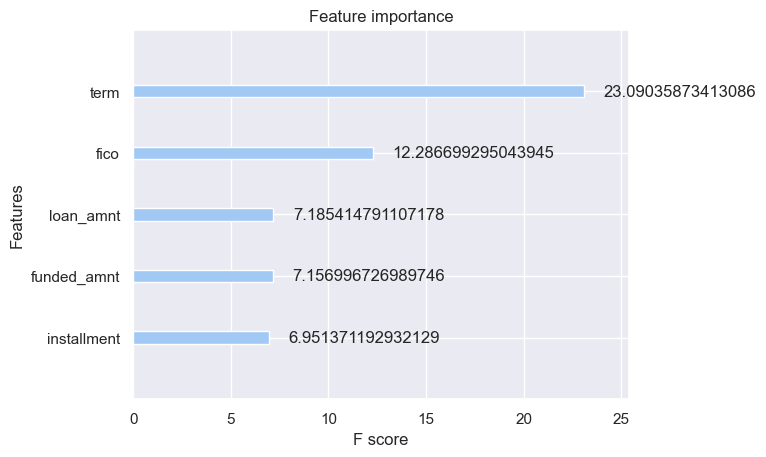

<IPython.core.display.Javascript object>

In [171]:
xgb.plot_importance(best_model_gr_xgb, max_num_features=5, importance_type="gain")
plt.show()

#### Results

XGBoost outperforms both Random Forest and Decision Tree models in terms of precision, recall, and F1-score. XGBoost achieves a significantly higher accuracy of 80%, whereas Random Forest and Decision Tree models have lower accuracies of 39% and 37%, respectively.

'term' (12/24 months) is the most significant feature in a model, with 'fico' score in second place and 'loan_amnt', 'funded_amnt', and 'installment' following in similar order of importance.

#### Saving model

I won't be saving the used scaler, as it used all columns, not only the selected features. We will use the same features for subgrade_int.rate models, and will use subgrade model scaler for all 3 models. 

In [161]:
if not blob_model_grade.exists():
    byte_stream = BytesIO()
    joblib.dump(best_model_gr_xgb, byte_stream)
    byte_stream.seek(0)

    blob_model_grade.upload_from_file(
        byte_stream, content_type="application/octet-stream"
    )
    print(f"XGB model saved to GCP bucket: {blob_model_grade}")

<IPython.core.display.Javascript object>

### Model for Subgrade

In [172]:
blob_subgr_model = bucket.blob(f"models/model_subgrade.pkl")

<IPython.core.display.Javascript object>

In [173]:
df_subgrade = df_accepted[selected_columns]

<IPython.core.display.Javascript object>

In [174]:
df_subgrade["sub_grade"] = subgrades
df_subgrade["grade"] = grades_enc

<IPython.core.display.Javascript object>

In [175]:
subgrade_map = {
    "A1": 0,
    "A2": 1,
    "A3": 2,
    "A4": 3,
    "A5": 4,
    "B1": 5,
    "B2": 6,
    "B3": 7,
    "B4": 8,
    "B5": 9,
    "C1": 10,
    "C2": 11,
    "C3": 12,
    "C4": 13,
    "C5": 14,
    "D1": 15,
    "D2": 16,
    "D3": 17,
    "D4": 18,
    "D5": 19,
    "E1": 20,
    "E2": 21,
    "E3": 22,
    "E4": 23,
    "E5": 24,
    "F1": 25,
    "F2": 26,
    "F3": 27,
    "F4": 28,
    "F5": 29,
    "G1": 30,
    "G2": 31,
    "G3": 32,
    "G4": 33,
    "G5": 34,
}

df_subgrade["sub_grade"] = df_subgrade["sub_grade"].map(subgrade_map)

<IPython.core.display.Javascript object>

In [176]:
X_train_sg, X_test_sg, y_train_sg, y_test_sg = train_test_sets(df_subgrade, "sub_grade")

<IPython.core.display.Javascript object>

#### Balancing data

In [177]:
y_train_sg.value_counts()

10    118917
9     114178
8     113891
11    106699
12    106503
7     105889
13    105207
6     103345
5     102408
14     96638
4      87609
3      76559
0      71448
15     66776
2      59055
16     58886
1      56362
17     52345
18     46076
19     38833
20     27096
21     24300
22     21613
24     18436
23     18423
25     10817
26      7499
27      6299
28      4960
29      4177
30      3266
31      2160
32      1719
33      1357
34      1245
Name: sub_grade, dtype: int64

<IPython.core.display.Javascript object>

I have decided to undersample all the values to 3000, and for F1-F5 sub-grades (30-34) and do not create syntethic values. I believe we should be very careful when creating variables with financial data, as there are no exact boundaries of values that can be fitted in, and it would be better to use less original values than creating new ones, risk by overfitting the model and tune it out for lower subgrades. I will use a higher number of cross validation.

In [178]:
sampling_strategy_dict_0_29 = {i: 3000 for i in range(29)}
rus = RandomUnderSampler(sampling_strategy=sampling_strategy_dict_0_29)

X_train_sg, y_train_sg = rus.fit_resample(X_train_sg, y_train_sg)
print("Class distribution after random undersampling:", Counter(y_train_sg))


Class distribution after random undersampling: Counter({29: 4177, 30: 3266, 0: 3000, 1: 3000, 2: 3000, 3: 3000, 4: 3000, 5: 3000, 6: 3000, 7: 3000, 8: 3000, 9: 3000, 10: 3000, 11: 3000, 12: 3000, 13: 3000, 14: 3000, 15: 3000, 16: 3000, 17: 3000, 18: 3000, 19: 3000, 20: 3000, 21: 3000, 22: 3000, 23: 3000, 24: 3000, 25: 3000, 26: 3000, 27: 3000, 28: 3000, 31: 2160, 32: 1719, 33: 1357, 34: 1245})


<IPython.core.display.Javascript object>

In [179]:
X_train_sg["dti"] = median_inputer.fit_transform(X_train_sg[["dti"]])
X_test_sg["dti"] = median_inputer.fit_transform(X_test_sg[["dti"]])

<IPython.core.display.Javascript object>

In [180]:
cols_to_scale_sg = [
    "total_bal_ex_mort",
    "total_bc_limit",
    "bc_util",
    "annual_inc",
    "dti",
    "revol_bal",
    "revol_util",
    "total_acc",
    "avg_cur_bal",
    "bc_open_to_buy",
    "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op",
    "mo_sin_rcnt_rev_tl_op",
    "mo_sin_rcnt_tl",
    "mths_since_recent_bc",
    "mths_since_recent_inq",
    "num_rev_accts",
    "tot_hi_cred_lim",
    "total_il_high_credit_limit",
    "fico",
    "funded_amnt",
    "installment",
    "monthly_load",
    "loan_amnt",
]

scaler_sg = StandardScaler()
X_train_sg[cols_to_scale_sg] = scaler_sg.fit_transform(X_train_sg[cols_to_scale_sg])
X_test_sg[cols_to_scale_sg] = scaler_sg.transform(X_test_sg[cols_to_scale_sg])

<IPython.core.display.Javascript object>

#### Hyperparameting

#### XGBoost 

In [181]:
if not blob_subgr_model.exists():
    space_xgb_sg = {
        "n_estimators": hp.choice("n_estimators", [10, 50, 100, 250, 500]),
        "max_depth": hp.choice("max_depth", [2, 3, 4, 5, 6]),
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
        "subsample": hp.uniform("subsample", 0.3, 0.9),
        "colsample_bytree:": hp.uniform("colsample_bytree:", 0.3, 0.9),
        "gamma": hp.uniform("gamma", 0, 0.3),
    }

    def objective_xgb_sg(params):
        clf = XGBClassifier(**params, random_state=42)
        score = cross_val_score(clf, X_train_sg, y_train_sg, cv=5).mean()
        return -score

    trials_sg_xgb = Trials()

    best = fmin(
        fn=objective_xgb_sg,
        space=space_xgb_sg,
        algo=tpe.suggest,
        max_evals=60,
        trials=trials_sg_xgb,
        rstate=None,
    )

    print("Best Hyperparameters:", best)

<IPython.core.display.Javascript object>

In [182]:
if not blob_subgr_model.exists():
    best_params_sg_xgb = space_eval(space_xgb_sg, best)
    best_model_sg_xgb = XGBClassifier(**best_params_sg_xgb, random_state=42)
    best_model_sg_xgb.fit(X_train_sg, y_train_sg)

<IPython.core.display.Javascript object>

#### Random Forest


In [183]:
if not blob_subgr_model.exists():
    space_rf_sg = {
        "n_estimators": hp.choice("n_estimators_rf", [5, 10, 25, 50, 100, 250, 500]),
        "max_depth": hp.choice("max_depth_rf", [2, 3, 4, 5, 6]),
        "min_samples_split": hp.choice("min_samples_split_rf", [5, 10, 15, 25, 50, 75]),
    }

    def objective_rf_sg(params):
        clf = RandomForestClassifier(**params, random_state=42)
        score = cross_val_score(clf, X_train_sg, y_train_sg, cv=5).mean()
        return -score

    trials_rf_sg = Trials()

    best_rf_sg = fmin(
        fn=objective_rf_sg,
        space=space_rf_sg,
        algo=tpe.suggest,
        max_evals=60,
        trials=trials_rf_sg,
        rstate=None,
    )

    print("Best Hyperparameters for Random Forest: ", best_rf_sg)

<IPython.core.display.Javascript object>

In [184]:
if not blob_subgr_model.exists():
    best_params_sg_rf = space_eval(space_rf, best_rf_sg)
    best_model_sg_rf = RandomForestClassifier(**best_params_sg_rf, random_state=42)
    best_model_sg_rf.fit(X_train_sg, y_train_sg)

<IPython.core.display.Javascript object>

#### Decision Tree

In [185]:
if not blob_subgr_model.exists():
    space_dt = {
        "max_depth": hp.choice("max_depth_dt", [2, 3, 4, 5, 6]),
        "min_samples_split": hp.choice("min_samples_split_dt", [5, 10, 15, 25, 50, 75]),
    }

    def objective_dt_sg(params):
        clf = DecisionTreeClassifier(**params, random_state=42)
        score = cross_val_score(clf, X_train_sg, y_train_sg, cv=5).mean()
        return -score

    trials_dt_sg = Trials()

    best_dt_sg = fmin(
        fn=objective_dt_sg,
        space=space_dt,
        algo=tpe.suggest,
        max_evals=60,
        trials=trials_dt_sg,
        rstate=None,
    )

    print("Best Hyperparameters for Random Forest: ", best_dt_sg)

<IPython.core.display.Javascript object>

In [186]:
if not blob_subgr_model.exists():
    best_params_sg_dt = space_eval(space_dt, best_dt_sg)
    best_model_sg_dt = DecisionTreeClassifier(**best_params_sg_dt, random_state=42)
    best_model_sg_dt.fit(X_train_sg, y_train_sg)

<IPython.core.display.Javascript object>

#### Results

In [210]:
if blob_model_grade.exists():
    print(f"Loading model from GCS: {blob_subgr_model}")
    byte_stream = BytesIO()
    blob_subgr_model.download_to_file(byte_stream)
    byte_stream.seek(0)
    best_model_sg_xgb = joblib.load(byte_stream)

Loading model from GCS: <Blob: bucket-for-lending, models/model_subgrade.pkl, 1712070014331244>


<IPython.core.display.Javascript object>

In [187]:
#%%capture cap
if not blob_subgr_model.exists():
    
    y_pred_rf_sg = best_model_sg_rf.predict(X_test_sg)
    y_pred_xgb_sg = best_model_sg_xgb.predict(X_test_sg)
    y_pred_dc_sg = best_model_sg_dt.predict(X_test_sg)

    print("Random Forest Performance:")
    print(classification_report(y_test_sg, y_pred_rf_sg))

    print("XGBoost Performance:")
    print(classification_report(y_test_sg, y_pred_xgb_sg))

    print("Decision Tree Performance:")
    print(classification_report(y_test_sg, y_pred_dc_sg))

<IPython.core.display.Javascript object>

In [188]:
if not blob_subgr_model.exists():
    with open("models_comparison_output/subgrade_models_comparison.txt", "w") as file:
        file.write(cap.stdout)
    print(cap.stdout)
else:
    with open("models_comparison_output/subgrade_models_comparison.txt", "r") as file:
        contents = file.read()
        print(contents)

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.37      0.53      0.44     15961
           1       0.22      0.19      0.20     12498
           2       0.21      0.20      0.20     13231
           3       0.40      0.11      0.17     17126
           4       0.40      0.57      0.47     19191
           5       0.23      0.57      0.32     22830
           6       0.25      0.08      0.12     23001
           7       0.22      0.11      0.14     23245
           8       0.32      0.09      0.15     25244
           9       0.29      0.48      0.36     25135
          10       0.28      0.45      0.35     26521
          11       0.22      0.19      0.21     23809
          12       0.23      0.06      0.09     23696
          13       0.24      0.24      0.24     23238
          14       0.25      0.23      0.24     21404
          15       0.35      0.09      0.15     15028
          16       0.23      0.35      0.28     13238


<IPython.core.display.Javascript object>

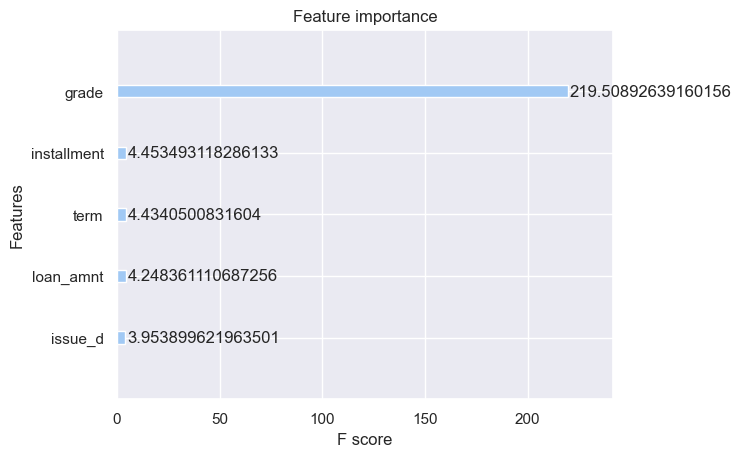

<IPython.core.display.Javascript object>

In [212]:
xgb.plot_importance(best_model_sg_xgb, max_num_features=5, importance_type="gain")
plt.show()

In a multi-class classification problem with 35 classes, obtaining a 48% accuracy using the XGBoost I belive is a good score. It suggests that the model is making better predictions than random chance, but there is room for improvement. Only XGBoost were able to classify worse subgrades 31-34 (G2-G5), but the f1-score compared to other sub_grades are much lower. I believe there is a lot of room for improvement, and we could try to do more of feature engineering or analysis of lower grades/subgrades to increase the performance.

As we coulod have expected grade is the most important feature for subgrade classification. The 2-5 place of importance shares 'installment', 'term', ' loan'amnt' and 'issue_d' features.


#### Saving model

In [217]:
blob_subgr_scaler = bucket.blob(f"scalers/scaler_grade.pkl")
if not blob_subgr_scaler.exists():
    byte_stream = BytesIO()
    joblib.dump(scaler_sg, byte_stream)
    byte_stream.seek(0)

    blob_subgr_scaler.upload_from_file(
        byte_stream, content_type="application/octet-stream"
    )
    print(f"XGB model saved to GCP bucket: {blob_subgr_scaler}")

XGB model saved to GCP bucket: <Blob: bucket-for-lending, scalers/scaler_grade.pkl, 1712323091107561>


<IPython.core.display.Javascript object>

In [191]:
if not blob_subgr_model.exists():
    byte_stream = BytesIO()
    joblib.dump(best_model_sg_xgb, byte_stream)
    byte_stream.seek(0)

    blob_subgr_model.upload_from_file(
        byte_stream, content_type="application/octet-stream"
    )
    print(f"XGB model saved to GCP bucket: {blob_subgr_model}")

<IPython.core.display.Javascript object>

#### Model for interest rate

In [192]:
blob_intr_model = bucket.blob(f"models/model_intr.pkl")

<IPython.core.display.Javascript object>

In [193]:
df_int_rate = df_subgrade.copy()

<IPython.core.display.Javascript object>

In [194]:
df_int_rate["int_rates"] = int_rates

<IPython.core.display.Javascript object>

In [195]:
df_int_rate

,loan_amnt,funded_amnt,term,installment,annual_inc,addr_state,dti,earliest_cr_line,revol_bal,revol_util,total_acc,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mths_since_recent_bc,mths_since_recent_inq,num_il_tl,num_rev_accts,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,fico,monthly_load,sub_grade,grade,int_rates
0,3600.00,3600.00,0,123.03,55000.00,38,0.06,2003,2765.00,29.70,13.00,144904.00,9300.00,4.00,20701.00,1506.00,37.20,148.00,128.00,3.00,3.00,4.00,4.00,3.00,9.00,178050.00,7746.00,2400.00,13734.00,677.00,2.68,13,4.00,13.99
1,24700.00,24700.00,0,820.28,65000.00,41,0.16,1999,21470.00,19.20,38.00,204396.00,111800.00,4.00,9733.00,57830.00,27.10,113.00,192.00,2.00,2.00,2.00,0.00,6.00,27.00,314017.00,39475.00,79300.00,24667.00,717.00,15.14,10,4.00,11.99
2,20000.00,20000.00,1,432.66,63000.00,14,0.11,2000,7869.00,56.20,18.00,189699.00,14000.00,6.00,31617.00,2737.00,55.90,125.00,184.00,14.00,14.00,101.00,10.00,6.00,7.00,218418.00,18696.00,6200.00,14877.00,697.00,8.24,8,5.00,10.78
3,35000.00,35000.00,1,829.90,110000.00,31,0.17,2008,7802.00,11.60,17.00,301500.00,67300.00,2.00,23192.00,54962.00,12.10,36.00,87.00,2.00,2.00,2.00,-1.00,2.00,13.00,381215.00,52226.00,62500.00,18000.00,787.00,9.05,14,4.00,14.85
4,10400.00,10400.00,1,289.91,104433.00,38,0.25,1998,21929.00,64.50,35.00,331730.00,34000.00,10.00,27644.00,4567.00,77.50,128.00,210.00,4.00,4.00,4.00,1.00,10.00,19.00,439570.00,95768.00,20300.00,88097.00,697.00,3.33,25,1.00,22.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2045541,24000.00,24000.00,1,543.50,95000.00,1,0.20,1999,49431.00,84.40,54.00,104422.00,50500.00,5.00,26106.00,-1.00,-1.00,201.00,88.00,3.00,3.00,-1.00,4.00,43.00,11.00,102517.00,104422.00,0.00,52017.00,667.00,6.87,10,4.00,12.79
2045542,24000.00,24000.00,1,515.74,108000.00,44,0.35,1991,21665.00,39.00,58.00,140118.00,55600.00,7.00,6369.00,15307.00,45.10,166.00,307.00,15.00,15.00,15.00,4.00,17.00,37.00,227883.00,140118.00,27900.00,172283.00,697.00,5.73,7,5.00,10.49
2045543,40000.00,40000.00,1,859.56,227000.00,4,0.13,1995,8633.00,64.90,37.00,28398.00,13300.00,2.00,5680.00,4070.00,66.90,154.00,258.00,33.00,15.00,41.00,1.00,9.00,23.00,55970.00,28398.00,12300.00,42670.00,707.00,4.54,7,5.00,10.49
2045544,24000.00,24000.00,1,564.56,110000.00,9,0.18,1999,17641.00,68.10,31.00,62426.00,25900.00,7.00,6243.00,4660.00,77.50,132.00,206.00,9.00,9.00,9.00,9.00,4.00,24.00,84664.00,62426.00,20700.00,58764.00,662.00,6.16,13,4.00,14.49


<IPython.core.display.Javascript object>

In [196]:
X_train_int, X_test_int, y_train_int, y_test_int = train_test_sets(
    df_int_rate, "int_rates"
)

<IPython.core.display.Javascript object>

In [197]:
X_train_int

,loan_amnt,funded_amnt,term,installment,annual_inc,addr_state,dti,earliest_cr_line,revol_bal,revol_util,total_acc,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mths_since_recent_bc,mths_since_recent_inq,num_il_tl,num_rev_accts,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,fico,monthly_load,sub_grade,grade
47101,18000.00,18000.00,1,421.92,52000.00,36,0.13,2006,18349.00,69.00,10.00,18349.00,26550.00,1.00,2038.00,2750.00,95.00,61.00,108.00,3.00,3.00,25.00,3.00,1.00,9.00,26550.00,18349.00,13750.00,0.00,667.00,9.74,14,4.00
25431,5875.00,5875.00,0,199.86,95000.00,34,0.09,2002,5719.00,56.60,10.00,292309.00,10100.00,6.00,58462.00,889.00,85.20,160.00,17.00,6.00,5.00,6.00,5.00,5.00,4.00,390898.00,34890.00,6000.00,30899.00,687.00,2.52,13,4.00
281181,15000.00,15000.00,0,500.30,40000.00,38,0.26,2008,18646.00,43.50,18.00,51348.00,42900.00,7.00,3668.00,21602.00,45.90,81.00,84.00,5.00,5.00,5.00,5.00,4.00,14.00,78047.00,51348.00,39900.00,35147.00,682.00,15.01,10,4.00
1713260,14000.00,14000.00,0,479.10,72002.00,37,0.20,1983,38309.00,83.80,20.00,38309.00,45700.00,0.00,3831.00,4274.00,89.90,132.00,363.00,53.00,53.00,53.00,0.00,4.00,16.00,45700.00,38309.00,42500.00,0.00,667.00,7.98,9,5.00
2003937,16000.00,16000.00,0,546.77,60000.00,43,0.19,2006,9723.00,52.80,34.00,40763.00,18400.00,4.00,4076.00,3550.00,62.20,123.00,118.00,10.00,10.00,15.00,11.00,24.00,10.00,53325.00,40763.00,9400.00,34925.00,687.00,10.94,12,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,7200.00,7200.00,0,235.69,59348.00,45,0.22,2000,10683.00,64.70,43.00,25555.00,16500.00,13.00,1825.00,4484.00,54.20,104.00,174.00,2.00,2.00,2.00,1.00,14.00,29.00,41269.00,25555.00,9800.00,24769.00,662.00,4.77,8,5.00
1414414,10000.00,10000.00,0,301.11,90000.00,29,0.14,2000,8414.00,34.30,18.00,37312.00,24500.00,7.00,5330.00,10637.00,21.20,212.00,137.00,19.00,1.00,19.00,19.00,13.00,5.00,66770.00,37312.00,13500.00,42270.00,722.00,4.01,0,6.00
131932,17400.00,17400.00,1,398.85,90000.00,18,0.17,2008,7153.00,30.80,19.00,51303.00,23200.00,4.00,4275.00,3004.00,69.30,19.00,84.00,22.00,8.00,27.00,9.00,3.00,14.00,73425.00,51303.00,9800.00,50225.00,692.00,5.32,12,4.00
671155,2500.00,2500.00,0,78.22,50000.00,45,0.29,1990,2786.00,12.40,39.00,180329.00,22400.00,0.00,12022.00,7548.00,0.70,141.00,313.00,43.00,30.00,54.00,4.00,11.00,23.00,243909.00,51873.00,7600.00,57183.00,667.00,1.88,4,6.00


<IPython.core.display.Javascript object>

#### Filling missing values

In [198]:
X_train_int["dti"] = median_inputer.fit_transform(X_train_int[["dti"]])
X_test_int["dti"] = median_inputer.fit_transform(X_test_int[["dti"]])

<IPython.core.display.Javascript object>

In [199]:
X_train_int

,loan_amnt,funded_amnt,term,installment,annual_inc,addr_state,dti,earliest_cr_line,revol_bal,revol_util,total_acc,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mths_since_recent_bc,mths_since_recent_inq,num_il_tl,num_rev_accts,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,fico,monthly_load,sub_grade,grade
47101,18000.00,18000.00,1,421.92,52000.00,36,0.13,2006,18349.00,69.00,10.00,18349.00,26550.00,1.00,2038.00,2750.00,95.00,61.00,108.00,3.00,3.00,25.00,3.00,1.00,9.00,26550.00,18349.00,13750.00,0.00,667.00,9.74,14,4.00
25431,5875.00,5875.00,0,199.86,95000.00,34,0.09,2002,5719.00,56.60,10.00,292309.00,10100.00,6.00,58462.00,889.00,85.20,160.00,17.00,6.00,5.00,6.00,5.00,5.00,4.00,390898.00,34890.00,6000.00,30899.00,687.00,2.52,13,4.00
281181,15000.00,15000.00,0,500.30,40000.00,38,0.26,2008,18646.00,43.50,18.00,51348.00,42900.00,7.00,3668.00,21602.00,45.90,81.00,84.00,5.00,5.00,5.00,5.00,4.00,14.00,78047.00,51348.00,39900.00,35147.00,682.00,15.01,10,4.00
1713260,14000.00,14000.00,0,479.10,72002.00,37,0.20,1983,38309.00,83.80,20.00,38309.00,45700.00,0.00,3831.00,4274.00,89.90,132.00,363.00,53.00,53.00,53.00,0.00,4.00,16.00,45700.00,38309.00,42500.00,0.00,667.00,7.98,9,5.00
2003937,16000.00,16000.00,0,546.77,60000.00,43,0.19,2006,9723.00,52.80,34.00,40763.00,18400.00,4.00,4076.00,3550.00,62.20,123.00,118.00,10.00,10.00,15.00,11.00,24.00,10.00,53325.00,40763.00,9400.00,34925.00,687.00,10.94,12,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,7200.00,7200.00,0,235.69,59348.00,45,0.22,2000,10683.00,64.70,43.00,25555.00,16500.00,13.00,1825.00,4484.00,54.20,104.00,174.00,2.00,2.00,2.00,1.00,14.00,29.00,41269.00,25555.00,9800.00,24769.00,662.00,4.77,8,5.00
1414414,10000.00,10000.00,0,301.11,90000.00,29,0.14,2000,8414.00,34.30,18.00,37312.00,24500.00,7.00,5330.00,10637.00,21.20,212.00,137.00,19.00,1.00,19.00,19.00,13.00,5.00,66770.00,37312.00,13500.00,42270.00,722.00,4.01,0,6.00
131932,17400.00,17400.00,1,398.85,90000.00,18,0.17,2008,7153.00,30.80,19.00,51303.00,23200.00,4.00,4275.00,3004.00,69.30,19.00,84.00,22.00,8.00,27.00,9.00,3.00,14.00,73425.00,51303.00,9800.00,50225.00,692.00,5.32,12,4.00
671155,2500.00,2500.00,0,78.22,50000.00,45,0.29,1990,2786.00,12.40,39.00,180329.00,22400.00,0.00,12022.00,7548.00,0.70,141.00,313.00,43.00,30.00,54.00,4.00,11.00,23.00,243909.00,51873.00,7600.00,57183.00,667.00,1.88,4,6.00


<IPython.core.display.Javascript object>

#### Scaling numeric values

In [200]:
X_train_int[cols_to_scale_sg] = scaler_sg.fit_transform(X_train_int[cols_to_scale_sg])
X_test_int[cols_to_scale_sg] = scaler_sg.transform(X_test_int[cols_to_scale_sg])

<IPython.core.display.Javascript object>

In [201]:
if not blob_intr_model.exists():
    space_xgb_int = {
        "n_estimators": hp.choice("n_estimators", [10, 50, 100, 250, 500]),
        "max_depth": hp.choice("max_depth", [2, 3, 4, 5, 6]),
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
        "subsample": hp.uniform("subsample", 0.3, 0.9),
        "colsample_bytree:": hp.uniform("colsample_bytree:", 0.3, 0.9),
        "gamma": hp.uniform("gamma", 0, 0.3),
    }

    def objective_xgb_int(params):
        clf = XGBRegressor(**params, random_state=42)
        score = cross_val_score(clf, X_train_int, y_train_int, cv=3).mean()
        return -score

    trials_int_xgb = Trials()

    best = fmin(
        fn=objective_xgb_int,
        space=space_xgb_int,
        algo=tpe.suggest,
        max_evals=60,
        trials=trials_int_xgb,
        rstate=None,
    )

    print("Best Hyperparameters:", best)

<IPython.core.display.Javascript object>

In [203]:
if not blob_intr_model.exists():
    best_params_int_xgb = space_eval(space_xgb_int, best)
    best_model_int_xgb = XGBRegressor(**best_params_int_xgb, random_state=42)
    best_model_int_xgb.fit(X_train_int, y_train_int)
    

<IPython.core.display.Javascript object>

In [216]:
if blob_intr_model.exists():
    print(f"Loading model from GCS: {blob_intr_model}")
    byte_stream = BytesIO()
    blob_intr_model.download_to_file(byte_stream)
    byte_stream.seek(0)
    best_model_int_xgb = joblib.load(byte_stream)

Loading model from GCS: <Blob: bucket-for-lending, models/model_intr.pkl, 1712072956017022>


<IPython.core.display.Javascript object>

In [205]:
# %%capture cap

if not blob_intr_model.exists():
    y_pred_xgb_int = best_model_int_xgb.predict(X_test_int)
    mse = mean_squared_error(y_test_int, y_pred_xgb_int)
    r2 = r2_score(y_test_int, y_pred_xgb_int)
    print("XGBoost Performance:")
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)

<IPython.core.display.Javascript object>

In [206]:
if not blob_intr_model.exists():
    with open("models_comparison_output/int_rate_model_comparison.txt", "w") as file:
            file.write(cap.stdout)
    print(cap.stdout)
else:
    with open("models_comparison_output/int_rate_model_comparison.txt", "r") as file:
        contents = file.read()
        print(contents)    


XGBoost Performance:
Mean Squared Error: 0.07834462190867107
R-squared Score: 0.9966783477770713



<IPython.core.display.Javascript object>

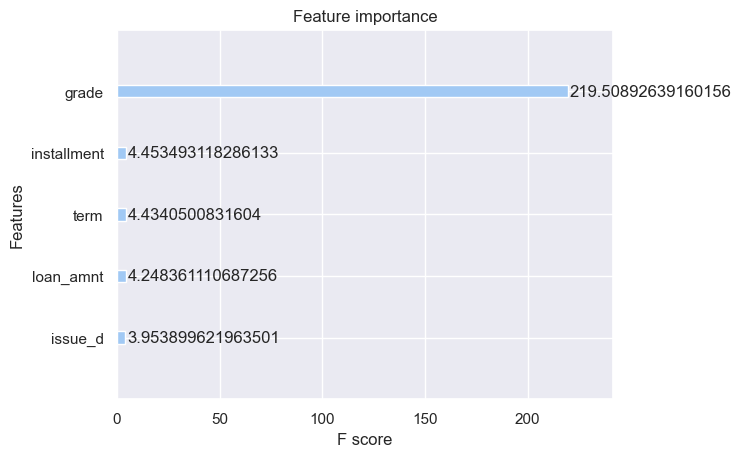

<IPython.core.display.Javascript object>

In [207]:
xgb.plot_importance(best_model_int_xgb, max_num_features=5, importance_type="gain")
plt.show()

The low MSE indicates that the model's predictions are very close to the actual values. The high R-squared score of 0.99
suggests that the model explains a significant portion of the variance in the data, indicating its strong predictive power. Feature importance is the same as in subgrade classification model. Grade is the most important feature following by 'installment', ' term', 'loan_amnt' and 'issue_d'.

#### Saving model

In [208]:
if not blob_intr_model.exists():
    byte_stream = BytesIO()
    joblib.dump(best_model_int_xgb, byte_stream)
    byte_stream.seek(0)

    blob_intr_model.upload_from_file(
        byte_stream, content_type="application/octet-stream"
    )
    print(f"XGB model saved to GCP bucket: {blob_intr_model}")

<IPython.core.display.Javascript object>